# Ensemble Model with Uncertainty Quantification

This notebook implements uncertainty quantification for multiclass classification using deep ensembles.  
We calculate **Total Uncertainty (TU)**, **Aleatoric Uncertainty (AU)**, and **Epistemic Uncertainty (EU)**.

In addition, we report calibration and probabilistic performance metrics commonly used for evaluating uncertainty quantification:

- **Brier Score**: Mean squared error between predicted probabilities and binary labels (lower is better).
- **Negative Log-Likelihood (NLL)**: Average binary cross-entropy; a proper scoring rule for probabilistic predictions.
- **Expected Calibration Error (ECE)**: Weighted average absolute gap between accuracy and confidence across probability bins (measures miscalibration).

In [1]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from tqdm.auto import tqdm
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve
import numpy as np
from torchvision.models import densenet121, DenseNet121_Weights, efficientnet_b2, EfficientNet_B2_Weights, efficientnet_b3, EfficientNet_B3_Weights
import matplotlib.pyplot as plt
import seaborn as sns
import glob, json
import warnings
from sklearn.metrics import roc_curve, auc
warnings.filterwarnings('ignore')

c:\Users\Yasiru Laksara\miniconda3\envs\torch_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
CONFIG = {
    'batch_size': 8,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'data_dir': './processed_images/data',
    'models_dir': './Final Models',
    'seed': 42
}
disease_list = [
    'Atelectasis','Cardiomegaly','Consolidation','Edema','Effusion',
    'Emphysema','Fibrosis','Hernia','Infiltration','Mass',
    'Nodule','Pleural_Thickening','Pneumonia','Pneumothorax'
]
print('Device:', CONFIG['device'])
print('Models dir:', CONFIG['models_dir'])
print('Number of classes:', len(disease_list))

Device: cuda
Models dir: ./Final Models
Number of classes: 14


In [3]:
# Data loading and preprocessing (same as original)
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

def get_label_vector(labels_str):
    labels = labels_str.split('|')
    if labels == ['No Finding']:
        return [0]*len(disease_list)
    return [1 if d in labels else 0 for d in disease_list]

class CheXNetDataset(Dataset):
    def __init__(self, df, image_to_folder, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_to_folder = image_to_folder
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = row['Image Index']
        folder = self.image_to_folder[img]
        path = os.path.join(folder, img)
        image = Image.open(path).convert('RGB')
        if self.transform: 
            image = self.transform(image)
        labels = torch.tensor(get_label_vector(row['Finding Labels']), dtype=torch.float)
        return image, labels

In [4]:
# Load CSV and map images
data_path = CONFIG['data_dir']
csv_file = os.path.join(data_path, 'Data_Entry_2017.csv')
df = pd.read_csv(csv_file)

# Map images to folders
image_folders = [os.path.join(data_path, f'images_{str(i).zfill(3)}','images') for i in range(1,13)]
image_to_folder = {}
for folder in image_folders:
    if os.path.exists(folder):
        for f in os.listdir(folder):
            if f.endswith('.png'): 
                image_to_folder[f] = folder

df = df[df['Image Index'].isin(image_to_folder.keys())].reset_index(drop=True)

# Split data (same as original)
unique_patients = df['Patient ID'].unique()
train_val_patients, test_patients = train_test_split(unique_patients, test_size=0.02, random_state=CONFIG['seed'])
train_patients, val_patients = train_test_split(train_val_patients, test_size=0.052, random_state=CONFIG['seed'])

test_df = df[df['Patient ID'].isin(test_patients)]
val_df = df[df['Patient ID'].isin(val_patients)]

valloader = DataLoader(CheXNetDataset(val_df, image_to_folder, transform=transform_test), 
                       batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0)
testloader = DataLoader(CheXNetDataset(test_df, image_to_folder, transform=transform_test), 
                        batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0)

print('Test size:', len(test_df), 'Val size:', len(val_df))

Test size: 2299 Val size: 5974


In [5]:
# Model creation functions (same as original)
def create_densenet_model():
    model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
    model.classifier = nn.Linear(model.classifier.in_features, 14)
    return model

def create_efficientnet_b2_model():
    model = efficientnet_b2(weights=EfficientNet_B2_Weights.IMAGENET1K_V1)
    num_features = model.classifier[1].in_features
    model.classifier = nn.Linear(num_features, 14)
    return model

def create_efficientnet_b3_model():
    model = efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1)
    num_features = model.classifier[1].in_features
    model.classifier = nn.Linear(num_features, 14)
    return model

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1
        
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.ca(x)
        x = x * self.sa(x)
        return x

class DenseNetCBAM(nn.Module):
    def __init__(self, num_classes=14):
        super(DenseNetCBAM, self).__init__()
        # Load pretrained DenseNet121
        self.densenet = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
        
        # Get the number of features from the last layer
        num_features = self.densenet.classifier.in_features
        
        # Remove the classifier layer
        self.densenet.classifier = nn.Identity()
        
        # Add CBAM attention after feature extraction
        self.attention = CBAM(num_features)
        
        # Add global average pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        # Add dropout and final classifier
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(num_features, num_classes)
        
    def forward(self, x):
        # Extract features using DenseNet backbone
        features = self.densenet.features(x)
        
        # Apply attention mechanism
        attended_features = self.attention(features)
        
        # Global average pooling
        pooled = self.global_pool(attended_features)
        pooled = pooled.view(pooled.size(0), -1)
        
        # Apply dropout and classifier
        output = self.dropout(pooled)
        output = self.classifier(output)
        
        return output

def create_densenet_attention_model():
    """Create DenseNet with CBAM attention mechanism"""
    return DenseNetCBAM(num_classes=14)

In [6]:
# Model detection and loading functions (same as original)
def detect_model_architecture(checkpoint_path):
    """Detect model architecture from checkpoint"""
    try:
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        if 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
        else:
            state_dict = checkpoint
        
        # Check for attention mechanism
        attention_keys = [k for k in state_dict.keys() if 'attention' in k.lower() or 'cbam' in k.lower()]
        if attention_keys:
            return 'densenet_attention'
        
        # Check for DenseNet
        densenet_keys = [k for k in state_dict.keys() if k.startswith('features.denseblock')]
        if densenet_keys:
            return 'densenet'
        
        # Check for EfficientNet
        efficientnet_variant = detect_efficientnet_variant(checkpoint_path)
        if efficientnet_variant != 'not_efficientnet':
            return efficientnet_variant
        
        return 'unknown'
    except Exception as e:
        print(f"Error detecting architecture: {e}")
        return 'error'

def detect_efficientnet_variant(checkpoint_path):
    """Detect EfficientNet variant (B2, B3, etc.) by inspecting first conv layer channels"""
    try:
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        if 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
        else:
            state_dict = checkpoint
        
        # Look for first conv layer to determine variant
        first_conv_key = 'features.0.0.weight'
        if first_conv_key in state_dict:
            out_channels = state_dict[first_conv_key].shape[0]
            
            # EfficientNet channel mappings
            variant_map = {
                32: 'efficientnet_b2',
                40: 'efficientnet_b3',
                48: 'efficientnet_b4',
            }
            
            if out_channels in variant_map:
                return variant_map[out_channels]
        
        return 'not_efficientnet'
    except Exception as e:
        return 'error'

def load_state_dict_flexible(model, checkpoint_path, device='cpu'):
    """Load checkpoint into model by matching keys and shapes where possible"""
    checkpoint = torch.load(checkpoint_path, map_location=device)
    if 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
    else:
        state_dict = checkpoint

    model_state = model.state_dict()
    loaded_keys = []
    skipped_missing = []
    skipped_shape = []

    # Create a mapping for key transformation
    state_dict_transformed = {}
    
    for k, v in state_dict.items():
        # Handle DenseNet with CBAM attention models
        if k.startswith('densenet.') and isinstance(model, DenseNetCBAM):
            # Remove 'densenet.' prefix for densenet backbone
            new_key = k.replace('densenet.', 'densenet.')
            state_dict_transformed[new_key] = v
        elif k.startswith('attention.') and isinstance(model, DenseNetCBAM):
            # Keep attention keys as is
            state_dict_transformed[k] = v
        elif k == 'classifier.weight' or k == 'classifier.bias':
            # Handle classifier keys
            state_dict_transformed[k] = v
        else:
            # Try direct mapping first
            state_dict_transformed[k] = v
            
            # Also try without any module prefixes
            if '.' in k:
                stripped_key = '.'.join(k.split('.')[1:])  # Remove first module name
                if stripped_key not in state_dict_transformed:
                    state_dict_transformed[stripped_key] = v

    # Now try to load the transformed state dict
    for k, v in state_dict_transformed.items():
        if k in model_state:
            if model_state[k].shape == v.shape:
                model_state[k] = v
                loaded_keys.append(k)
            else:
                skipped_shape.append((k, v.shape, model_state[k].shape))
        else:
            skipped_missing.append(k)

    model.load_state_dict(model_state)

    return {
        'loaded_keys': loaded_keys,
        'skipped_missing': skipped_missing,
        'skipped_shape': skipped_shape
    }

In [7]:
# Load models directly (without wrapper)
model_paths = glob.glob(os.path.join(CONFIG['models_dir'],'*.pth'))
models = []
model_names = []

for p in model_paths:
    try:
        arch = detect_model_architecture(p)
        if arch == 'densenet': 
            m = create_densenet_model()
            n = 'DenseNet121'
        elif arch == 'densenet_attention': 
            m = create_densenet_attention_model()
            n = 'DenseNet+CBAM'
        elif arch == 'efficientnet_b2': 
            m = create_efficientnet_b2_model()
            n = 'EfficientNet-B2'
        elif arch == 'efficientnet_b3': 
            m = create_efficientnet_b3_model()
            n = 'EfficientNet-B3'
        else: 
            print('Skip', os.path.basename(p))
            continue
        
        try:
            # Try strict load first
            m.load_state_dict(torch.load(p, map_location=CONFIG['device']))
        except Exception as e:
            print('Strict load failed for', os.path.basename(p), "-> trying flexible loader. Error:", e)
            info = load_state_dict_flexible(m, p, device=CONFIG['device'])
            print('Flexible loader report:', f"loaded {len(info['loaded_keys'])} keys, skipped {len(info['skipped_missing'])} missing, {len(info['skipped_shape'])} shape-mismatches")
            if len(info['loaded_keys']) == 0:
                print('No compatible keys loaded; skipping', os.path.basename(p))
                continue
        
        m.to(CONFIG['device'])
        m.eval()
        models.append(m)
        model_names.append(os.path.basename(p))
        print('Loaded', os.path.basename(p), n)
    except Exception as e:
        print('Fail', os.path.basename(p), e)

print('Total loaded models:', len(models))

Loaded seed 22 - densnet 121 - focal loss.pth DenseNet121
Loaded seed 22 - densnet 121 - ZLPR loss.pth DenseNet121
Loaded seed 22 - densnet 121 - ZLPR loss.pth DenseNet121
Loaded seed 32 - densenet 121 - ZLPR loss.pth DenseNet121
Loaded seed 32 - densenet 121 - ZLPR loss.pth DenseNet121
Loaded seed 32- densnet121 - focal loss.pth DenseNet121
Loaded seed 32- densnet121 - focal loss.pth DenseNet121
Loaded seed 42 - densnet 121 - focal loss.pth DenseNet121
Loaded seed 42 - densnet 121 - focal loss.pth DenseNet121
Loaded seed 42 - densnet 121 - ZLPR loss.pth DenseNet121
Loaded seed 42 - densnet 121 - ZLPR loss.pth DenseNet121
Loaded seed 42 - densnet121- Attention - focal loss.pth DenseNet+CBAM
Loaded seed 42 - densnet121- Attention - focal loss.pth DenseNet+CBAM
Loaded seed 42 - efficienet b3 - focal loss.pth EfficientNet-B3
Loaded seed 42 - efficienet b3 - focal loss.pth EfficientNet-B3
Loaded seed 42 - efficinet b2 - focal loss.pth EfficientNet-B2
Total loaded models: 9
Loaded seed 42 -

In [8]:
# Get predictions from all models
def get_predictions_with_logits(models, dataloader, device):
    """Get both softmax probabilities and raw logits for uncertainty quantification"""
    all_probs = []  # For ensemble prediction
    all_logits = []  # For uncertainty calculation
    labels = []
    
    with torch.no_grad():
        for x, y in tqdm(dataloader, desc="Getting predictions"):
            x = x.to(device)
            batch_probs = []
            batch_logits = []
            
            for m in models:
                logits = m(x)
                probs = torch.sigmoid(logits)  # For multilabel classification
                batch_probs.append(probs.cpu())
                batch_logits.append(logits.cpu())
            
            all_probs.append(torch.stack(batch_probs))
            all_logits.append(torch.stack(batch_logits))
            labels.append(y)
    
    all_probs = torch.cat(all_probs, dim=1)
    all_logits = torch.cat(all_logits, dim=1)
    labels = torch.cat(labels, dim=0)
    
    return all_probs.numpy(), all_logits.numpy(), labels.numpy()

print('Getting test predictions...')
test_probs, test_logits, test_labels = get_predictions_with_logits(models, testloader, CONFIG['device'])
print('Shapes - Probs:', test_probs.shape, 'Logits:', test_logits.shape, 'Labels:', test_labels.shape)
print('Probs shape: [num_models, num_samples, num_classes]')

Getting test predictions...


Getting predictions: 100%|██████████| 288/288 [01:45<00:00,  2.73it/s]

Shapes - Probs: (9, 2299, 14) Logits: (9, 2299, 14) Labels: (2299, 14)
Probs shape: [num_models, num_samples, num_classes]


In [9]:
# Simple average ensemble prediction
def simple_average(predictions):
    """predictions: [num_models, num_samples, num_classes]"""
    return np.mean(predictions, axis=0)

ensemble_test = simple_average(test_probs)

# Evaluation function
def evaluate_multiclass(labels, preds):
    """Evaluate multiclass classification performance"""
    thresholds = []
    for i in range(preds.shape[1]):
        p, r, t = precision_recall_curve(labels[:, i], preds[:, i])
        f1s = 2 * (p * r) / (p + r + 1e-8)
        thresholds.append(t[np.argmax(f1s)] if len(t) > 0 else 0.5)
    
    preds_b = np.zeros_like(preds)
    for i in range(preds.shape[1]): 
        preds_b[:, i] = (preds[:, i] > thresholds[i]).astype(int)
    
    aucs = [roc_auc_score(labels[:, i], preds[:, i]) for i in range(preds.shape[1])]
    f1s = [f1_score(labels[:, i], preds_b[:, i]) for i in range(preds.shape[1])]
    
    return {
        'avg_auc': np.mean(aucs),
        'avg_f1': np.mean(f1s),
        'aucs': aucs,
        'f1s': f1s,
        'thresholds': thresholds
    }

# Evaluate ensemble performance
test_res = evaluate_multiclass(test_labels, ensemble_test)
print(f'Ensemble Test AUROC: {test_res["avg_auc"]:.4f}')
print(f'Ensemble Test F1: {test_res["avg_f1"]:.4f}')

Ensemble Test AUROC: 0.8559
Ensemble Test F1: 0.3857


In [10]:
# Show individual model performance
individual_test_aurocs = []
individual_test_f1s = []

for i in range(test_probs.shape[0]):
    preds = test_probs[i]  # shape: [num_samples, num_classes]
    res = evaluate_multiclass(test_labels, preds)
    individual_test_aurocs.append(res['avg_auc'])
    individual_test_f1s.append(res['avg_f1'])

# Display individual model performance
individual_results_df = pd.DataFrame({
    'Model': model_names,
    'Test_AUROC': np.round(individual_test_aurocs, 4),
    'Test_F1': np.round(individual_test_f1s, 4)
})
print('\nIndividual Model Performance on Test Set:')
display(individual_results_df)

# Show per-class performance
perclass_df = pd.DataFrame({
    'Disease': disease_list,
    'AUROC': np.round(test_res['aucs'], 4),
    'F1_Score': np.round(test_res['f1s'], 4),
    'Threshold': np.round(test_res['thresholds'], 4)
})
print('\nPer-class performance (ensemble):')  
display(perclass_df)


Individual Model Performance on Test Set:


,Model,Test_AUROC,Test_F1
0,seed 22 - densnet 121 - focal loss.pth,0.8475,0.3852
1,seed 22 - densnet 121 - ZLPR loss.pth,0.8468,0.3758
2,seed 32 - densenet 121 - ZLPR loss.pth,0.8479,0.3762
3,seed 32- densnet121 - focal loss.pth,0.8458,0.3679
4,seed 42 - densnet 121 - focal loss.pth,0.8514,0.3803
5,seed 42 - densnet 121 - ZLPR loss.pth,0.8462,0.3621
6,seed 42 - densnet121- Attention - focal loss.pth,0.8480,0.3787
7,seed 42 - efficienet b3 - focal loss.pth,0.8117,0.3338
8,seed 42 - efficinet b2 - focal loss.pth,0.8322,0.3528



Per-class performance (ensemble):


,Disease,AUROC,F1_Score,Threshold
0,Atelectasis,0.8215,0.4084,0.2901
1,Cardiomegaly,0.9405,0.5035,0.3075
2,Consolidation,0.7834,0.2402,0.2359
3,Edema,0.8976,0.2635,0.2496
4,Effusion,0.9059,0.6245,0.3519
5,Emphysema,0.9705,0.5584,0.1980
6,Fibrosis,0.8448,0.1531,0.1738
7,Hernia,0.9937,0.7500,0.4296
8,Infiltration,0.7078,0.4145,0.3263
9,Mass,0.9126,0.4917,0.3570


## Uncertainty Quantification Implementation

Now we implement uncertainty quantification adapted for multiclass classification.
We calculate:
- **Total Uncertainty (TU)**: Entropy of the averaged predictions
- **Aleatoric Uncertainty (AU)**: Average entropy of individual model predictions  
- **Epistemic Uncertainty (EU)**: TU - AU (disagreement between models)

In [11]:
def binary_entropy(probs, epsilon=1e-10):
    """Calculate binary entropy for sigmoid probabilities"""
    probs = np.clip(probs, epsilon, 1 - epsilon)
    return -probs * np.log(probs) - (1 - probs) * np.log(1 - probs)

def calculate_uncertainty_multilabel(model_predictions):
    """
    Calculate uncertainty measures for multilabel classification with sigmoid outputs.
    Treats each class independently as per the research paper formulation.
    
    Args:
        model_predictions: numpy array of shape [num_models, num_samples, num_classes]
    
    Returns:
        dict containing uncertainty measures
    """
    num_models, num_samples, num_classes = model_predictions.shape
    
    # Calculate per-class uncertainties
    per_class_tu = np.zeros((num_samples, num_classes))
    per_class_au = np.zeros((num_samples, num_classes))
    per_class_eu = np.zeros((num_samples, num_classes))
    
    for c in range(num_classes):
        # Get predictions for this class across all models
        class_preds = model_predictions[:, :, c]  # [num_models, num_samples]
        
        # Ensemble prediction for this class
        ensemble_pred_class = np.mean(class_preds, axis=0)  # [num_samples]
        
        # Total uncertainty for this class
        per_class_tu[:, c] = binary_entropy(ensemble_pred_class)
        
        # Aleatoric uncertainty for this class
        model_entropies = np.array([binary_entropy(class_preds[m]) for m in range(num_models)])
        per_class_au[:, c] = np.mean(model_entropies, axis=0)
        
        # Epistemic uncertainty for this class
        per_class_eu[:, c] = per_class_tu[:, c] - per_class_au[:, c]
    
    # Aggregate across classes (mean)
    total_uncertainty = np.mean(per_class_tu, axis=1)
    aleatoric_uncertainty = np.mean(per_class_au, axis=1)
    epistemic_uncertainty = np.mean(per_class_eu, axis=1)
    
    return {
        'total_uncertainty': total_uncertainty,
        'aleatoric_uncertainty': aleatoric_uncertainty,
        'epistemic_uncertainty': epistemic_uncertainty,
        'per_class_tu': per_class_tu,
        'per_class_au': per_class_au,
        'per_class_eu': per_class_eu,
        'ensemble_prediction': np.mean(model_predictions, axis=0)
    }

# Calculate uncertainties
print('Calculating uncertainty measures...')
uncertainty_results = calculate_uncertainty_multilabel(test_probs)

print(f"Total Uncertainty - Mean: {np.mean(uncertainty_results['total_uncertainty']):.4f}, Std: {np.std(uncertainty_results['total_uncertainty']):.4f}")
print(f"Aleatoric Uncertainty - Mean: {np.mean(uncertainty_results['aleatoric_uncertainty']):.4f}, Std: {np.std(uncertainty_results['aleatoric_uncertainty']):.4f}")
print(f"Epistemic Uncertainty - Mean: {np.mean(uncertainty_results['epistemic_uncertainty']):.4f}, Std: {np.std(uncertainty_results['epistemic_uncertainty']):.4f}")

# Maximum possible uncertainty per class is log(2), averaged across classes
max_uncertainty_per_class = np.log(2)
print(f"\nMaximum possible uncertainty per class: {max_uncertainty_per_class:.4f}")
print(f"Uncertainty utilization: {np.mean(uncertainty_results['total_uncertainty'])/max_uncertainty_per_class*100:.2f}%")

Calculating uncertainty measures...
Total Uncertainty - Mean: 0.3312, Std: 0.0730
Aleatoric Uncertainty - Mean: 0.3073, Std: 0.0720
Epistemic Uncertainty - Mean: 0.0240, Std: 0.0036

Maximum possible uncertainty per class: 0.6931
Uncertainty utilization: 47.79%


In [12]:
# Display per-class uncertainty statistics
per_class_uncertainty_stats = []

for i, disease in enumerate(disease_list):
    per_class_uncertainty_stats.append({
        'Disease': disease,
        'TU (Total Uncertainty)': np.mean(uncertainty_results['per_class_tu'][:, i]),
        'AU (Aleatoric Uncertainty)': np.mean(uncertainty_results['per_class_au'][:, i]),
        'EU (Epistemic Uncertainty)': np.mean(uncertainty_results['per_class_eu'][:, i]),
        'TU_Std': np.std(uncertainty_results['per_class_tu'][:, i]),
        'AU_Std': np.std(uncertainty_results['per_class_au'][:, i]),
        'EU_Std': np.std(uncertainty_results['per_class_eu'][:, i])
    })

per_class_uncertainty_df = pd.DataFrame(per_class_uncertainty_stats)
per_class_uncertainty_df = per_class_uncertainty_df.round(4)

print('Per-class Uncertainty Statistics:')
display(per_class_uncertainty_df)

Per-class Uncertainty Statistics:


,Disease,TU (Total Uncertainty),AU (Aleatoric Uncertainty),EU (Epistemic Uncertainty),TU_Std,AU_Std,EU_Std
0,Atelectasis,0.4512,0.4267,0.0245,0.1344,0.1379,0.0079
1,Cardiomegaly,0.2716,0.2467,0.0249,0.1573,0.1486,0.0116
2,Consolidation,0.3664,0.3418,0.0246,0.1206,0.1207,0.0050
3,Edema,0.2448,0.2235,0.0213,0.1502,0.1424,0.0097
4,Effusion,0.4444,0.4209,0.0235,0.1638,0.1664,0.0078
5,Emphysema,0.2404,0.2165,0.0239,0.1158,0.1067,0.0115
6,Fibrosis,0.2687,0.2432,0.0255,0.1154,0.1081,0.0091
7,Hernia,0.0937,0.0805,0.0133,0.0587,0.0458,0.0151
8,Infiltration,0.5660,0.5467,0.0193,0.0806,0.0882,0.0089
9,Mass,0.3570,0.3287,0.0283,0.1270,0.1246,0.0081


In [13]:
# Additional Metrics: Brier Score, ECE, and NLL
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix

def brier_score_multilabel(y_true, y_prob):
    """Calculate Brier score for multilabel classification"""
    return np.mean((y_prob - y_true) ** 2)

def expected_calibration_error(y_true, y_prob, n_bins=10):
    """Calculate Expected Calibration Error (ECE)"""
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    ece = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Determine if sample is in bin m (between bin_lower and bin_upper)
        in_bin = (y_prob > bin_lower) & (y_prob <= bin_upper)
        prop_in_bin = in_bin.mean()
        
        if prop_in_bin > 0:
            accuracy_in_bin = y_true[in_bin].mean()
            avg_confidence_in_bin = y_prob[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
    return ece

def negative_log_likelihood(y_true, y_prob, epsilon=1e-15):
    """Calculate Negative Log-Likelihood for binary classification"""
    y_prob = np.clip(y_prob, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(y_prob) + (1 - y_true) * np.log(1 - y_prob))

def calculate_additional_metrics(y_true, y_pred, disease_names):
    """Calculate Brier score, ECE, and NLL for each class"""
    num_classes = y_true.shape[1]
    metrics = {
        'brier_scores': [],
        'ece_scores': [],
        'nll_scores': [],
        'disease_names': disease_names
    }
    
    for i in range(num_classes):
        # Per-class metrics
        brier = brier_score_multilabel(y_true[:, i], y_pred[:, i])
        ece = expected_calibration_error(y_true[:, i], y_pred[:, i])
        nll = negative_log_likelihood(y_true[:, i], y_pred[:, i])
        
        metrics['brier_scores'].append(brier)
        metrics['ece_scores'].append(ece)
        metrics['nll_scores'].append(nll)
    
    # Calculate means
    metrics['mean_brier'] = np.mean(metrics['brier_scores'])
    metrics['mean_ece'] = np.mean(metrics['ece_scores'])
    metrics['mean_nll'] = np.mean(metrics['nll_scores'])
    
    return metrics

# Calculate additional metrics for ensemble predictions
print('Calculating additional metrics (Brier Score, ECE, NLL)...')
# Convert tensor to numpy array if needed
test_labels_np = test_labels.cpu().numpy() if hasattr(test_labels, 'cpu') else test_labels
additional_metrics = calculate_additional_metrics(test_labels_np, ensemble_test, disease_list)

print(f"Mean Brier Score: {additional_metrics['mean_brier']:.4f}")
print(f"Mean ECE: {additional_metrics['mean_ece']:.4f}")
print(f"Mean NLL: {additional_metrics['mean_nll']:.4f}")

Calculating additional metrics (Brier Score, ECE, NLL)...
Mean Brier Score: 0.0478
Mean ECE: 0.0728
Mean NLL: 0.1916


In [14]:
# Create comprehensive per-class metrics table
comprehensive_metrics = []

for i, disease in enumerate(disease_list):
    comprehensive_metrics.append({
        'Disease': disease,
        'AUROC': test_res['aucs'][i],
        'F1_Score': test_res['f1s'][i],
        'Brier_Score': additional_metrics['brier_scores'][i],
        'ECE': additional_metrics['ece_scores'][i],
        'NLL': additional_metrics['nll_scores'][i],
        'TU_Mean': np.mean(uncertainty_results['per_class_tu'][:, i]),
        'AU_Mean': np.mean(uncertainty_results['per_class_au'][:, i]),
        'EU_Mean': np.mean(uncertainty_results['per_class_eu'][:, i])
    })

comprehensive_metrics_df = pd.DataFrame(comprehensive_metrics)
comprehensive_metrics_df = comprehensive_metrics_df.round(4)

print('Comprehensive Per-class Metrics:')
display(comprehensive_metrics_df)

# Summary statistics
print('\nSummary Statistics:')
summary_stats = {
    'Metric': ['AUROC', 'F1_Score', 'Brier_Score', 'ECE', 'NLL', 'Total_Uncertainty', 'Aleatoric_Uncertainty', 'Epistemic_Uncertainty'],
    'Mean': [
        np.mean(test_res['aucs']),
        np.mean(test_res['f1s']),
        additional_metrics['mean_brier'],
        additional_metrics['mean_ece'],
        additional_metrics['mean_nll'],
        np.mean(uncertainty_results['total_uncertainty']),
        np.mean(uncertainty_results['aleatoric_uncertainty']),
        np.mean(uncertainty_results['epistemic_uncertainty'])
    ],
    'Std': [
        np.std(test_res['aucs']),
        np.std(test_res['f1s']),
        np.std(additional_metrics['brier_scores']),
        np.std(additional_metrics['ece_scores']),
        np.std(additional_metrics['nll_scores']),
        np.std([np.mean(uncertainty_results['per_class_tu'][:, i]) for i in range(len(disease_list))]),
        np.std([np.mean(uncertainty_results['per_class_au'][:, i]) for i in range(len(disease_list))]),
        np.std([np.mean(uncertainty_results['per_class_eu'][:, i]) for i in range(len(disease_list))])
    ]
}

summary_df = pd.DataFrame(summary_stats).round(4)
display(summary_df)

Comprehensive Per-class Metrics:


,Disease,AUROC,F1_Score,Brier_Score,ECE,NLL,TU_Mean,AU_Mean,EU_Mean
0,Atelectasis,0.8215,0.4084,0.0841,0.0953,0.3037,0.4512,0.4267,0.0245
1,Cardiomegaly,0.9405,0.5035,0.0383,0.0508,0.1527,0.2716,0.2467,0.0249
2,Consolidation,0.7834,0.2402,0.0476,0.0868,0.2053,0.3664,0.3418,0.0246
3,Edema,0.8976,0.2635,0.0243,0.0570,0.1165,0.2448,0.2235,0.0213
4,Effusion,0.9059,0.6245,0.0885,0.0922,0.3062,0.4444,0.4209,0.0235
5,Emphysema,0.9705,0.5584,0.0208,0.0567,0.1057,0.2404,0.2165,0.0239
6,Fibrosis,0.8448,0.1531,0.0212,0.0679,0.1172,0.2687,0.2432,0.0255
7,Hernia,0.9937,0.7500,0.0021,0.0195,0.0241,0.0937,0.0805,0.0133
8,Infiltration,0.7078,0.4145,0.1402,0.1006,0.4524,0.5660,0.5467,0.0193
9,Mass,0.9126,0.4917,0.0430,0.0873,0.1877,0.3570,0.3287,0.0283



Summary Statistics:


,Metric,Mean,Std
0,AUROC,0.8559,0.0855
1,F1_Score,0.3857,0.1816
2,Brier_Score,0.0478,0.0346
3,ECE,0.0728,0.0209
4,NLL,0.1916,0.1037
5,Total_Uncertainty,0.3312,0.1106
6,Aleatoric_Uncertainty,0.3073,0.1094
7,Epistemic_Uncertainty,0.0240,0.0037


## Comprehensive Visualization Suite

This section provides detailed visualizations for model performance, uncertainty analysis, and calibration assessment.

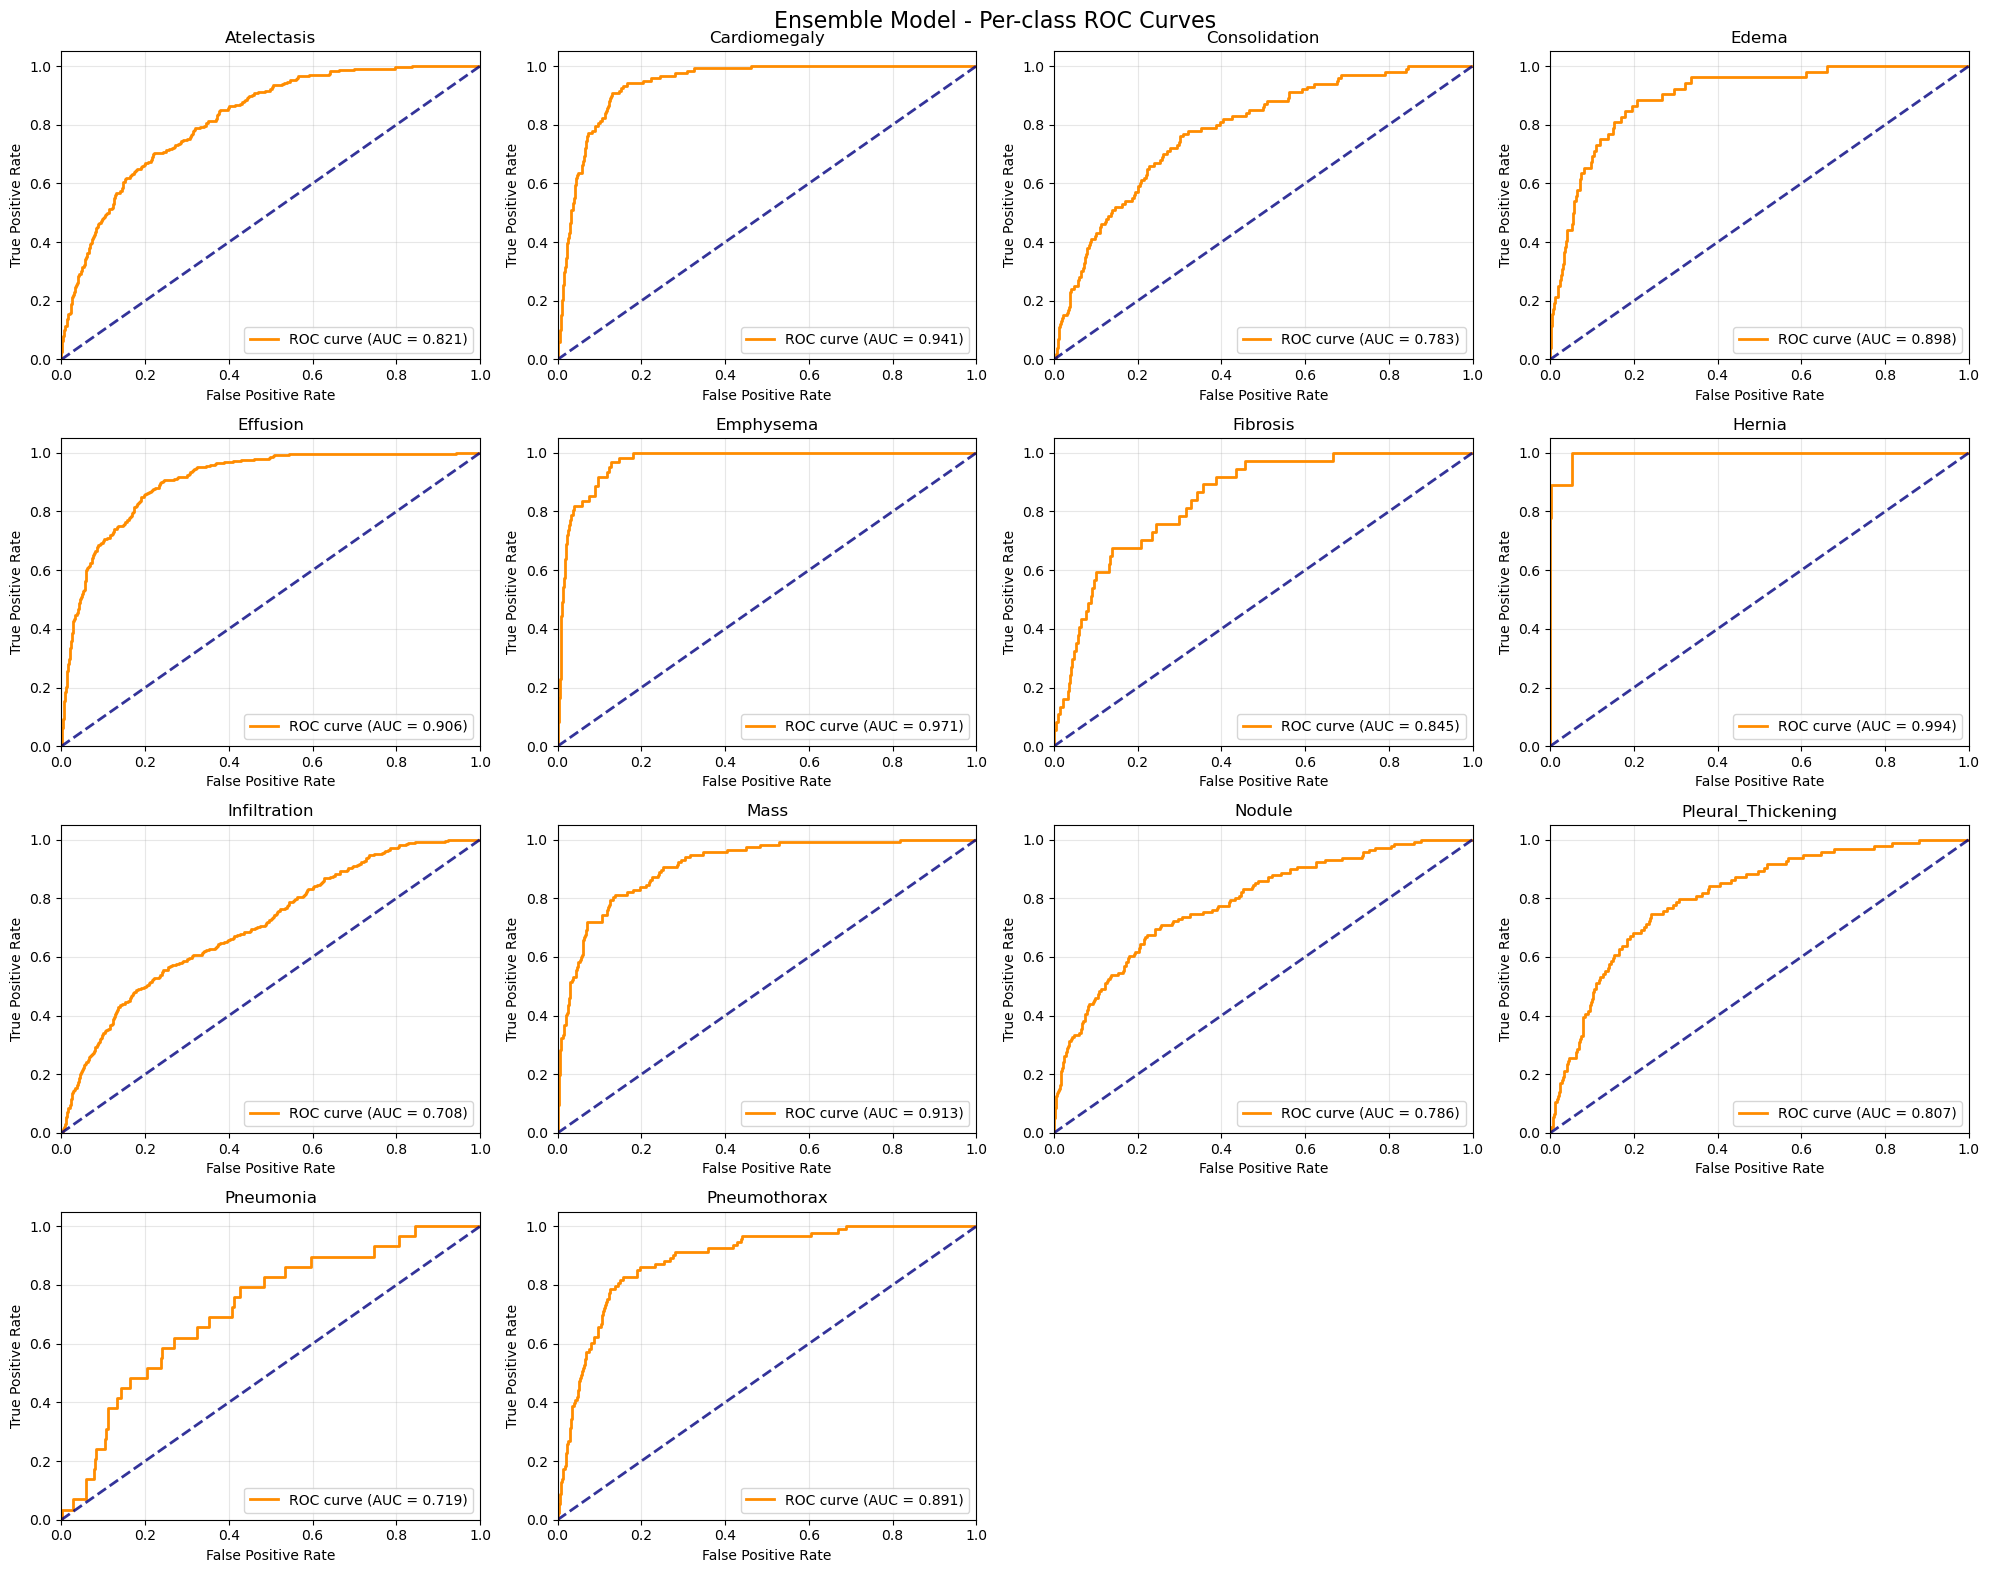

In [15]:
def plot_per_class_roc_curves(y_true, y_pred, disease_names, title="Per-class ROC Curves"):
    """Plot ROC curves for each disease class"""
    fig, axes = plt.subplots(4, 4, figsize=(20, 16))
    axes = axes.ravel()
    
    for i, disease in enumerate(disease_names):
        if i < len(axes):
            fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
            roc_auc = auc(fpr, tpr)
            
            axes[i].plot(fpr, tpr, color='darkorange', lw=2, 
                        label=f'ROC curve (AUC = {roc_auc:.3f})')
            axes[i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.8)
            axes[i].set_xlim([0.0, 1.0])
            axes[i].set_ylim([0.0, 1.05])
            axes[i].set_xlabel('False Positive Rate')
            axes[i].set_ylabel('True Positive Rate')
            axes[i].set_title(f'{disease}')
            axes[i].legend(loc="lower right")
            axes[i].grid(True, alpha=0.3)
    
    # Hide empty subplots
    for i in range(len(disease_names), len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle(title, fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

# Plot ROC curves
plot_per_class_roc_curves(test_labels_np, ensemble_test, disease_list, "Ensemble Model - Per-class ROC Curves")

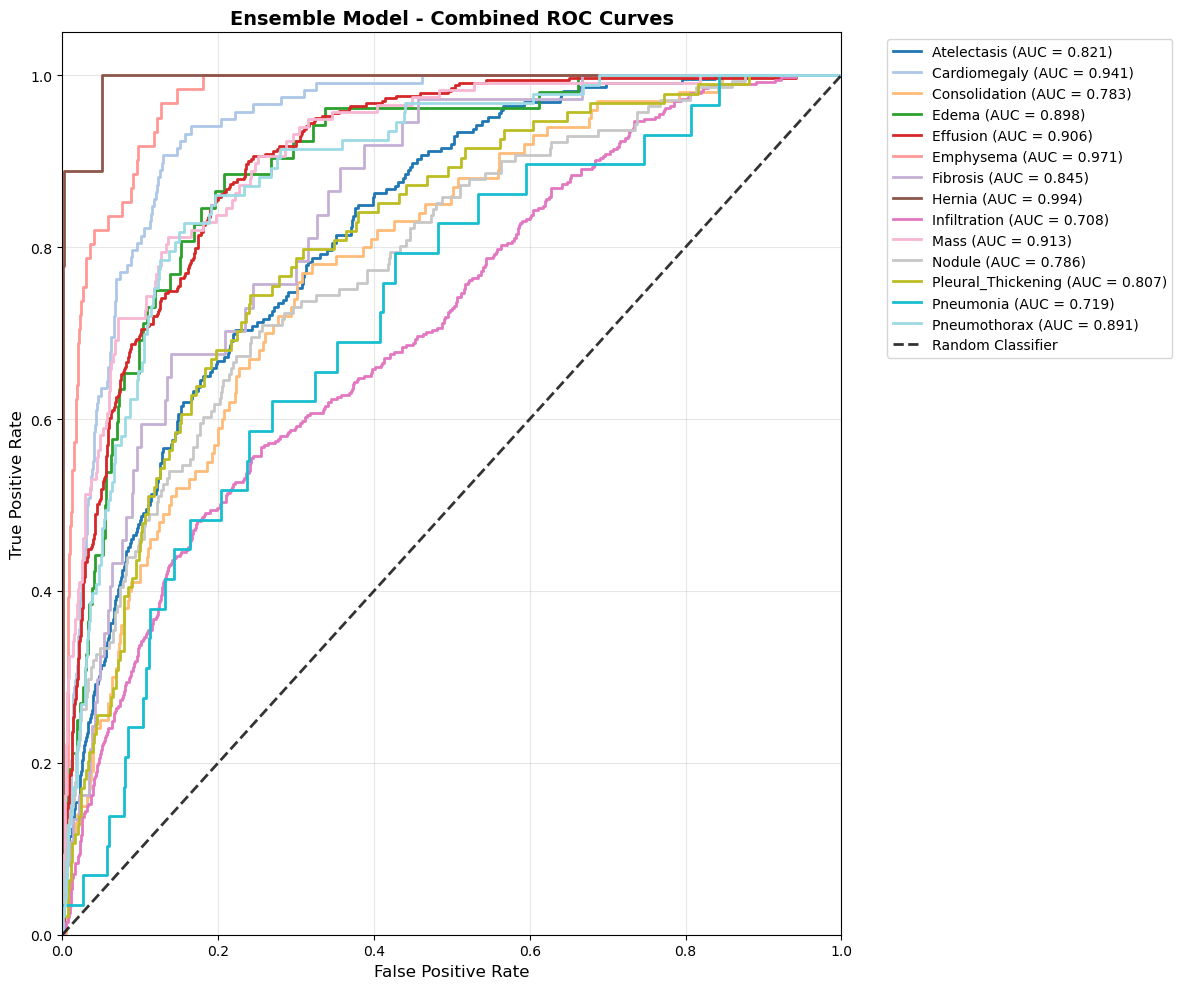

In [16]:
# Combined ROC Curve Plot - All Classes in One
def plot_combined_roc_curves(y_true, y_pred, disease_names, title="Combined ROC Curves - All Classes"):
    """Plot all ROC curves in a single plot for comparison"""
    plt.figure(figsize=(12, 10))
    
    # Generate colors for each disease
    colors = plt.cm.tab20(np.linspace(0, 1, len(disease_names)))
    
    auc_scores = []
    
    for i, (disease, color) in enumerate(zip(disease_names, colors)):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        auc_scores.append(roc_auc)
        
        plt.plot(fpr, tpr, color=color, lw=2, 
                label=f'{disease} (AUC = {roc_auc:.3f})')
    
    # Plot diagonal reference line
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', alpha=0.8, label='Random Classifier')
    
    # Customize plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    
    # Create legend with two columns to fit all diseases
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1, fontsize=10)
    
    # Add grid
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return auc_scores

# Plot combined ROC curves
combined_auc_scores = plot_combined_roc_curves(test_labels_np, ensemble_test, disease_list, 
                                               "Ensemble Model - Combined ROC Curves")

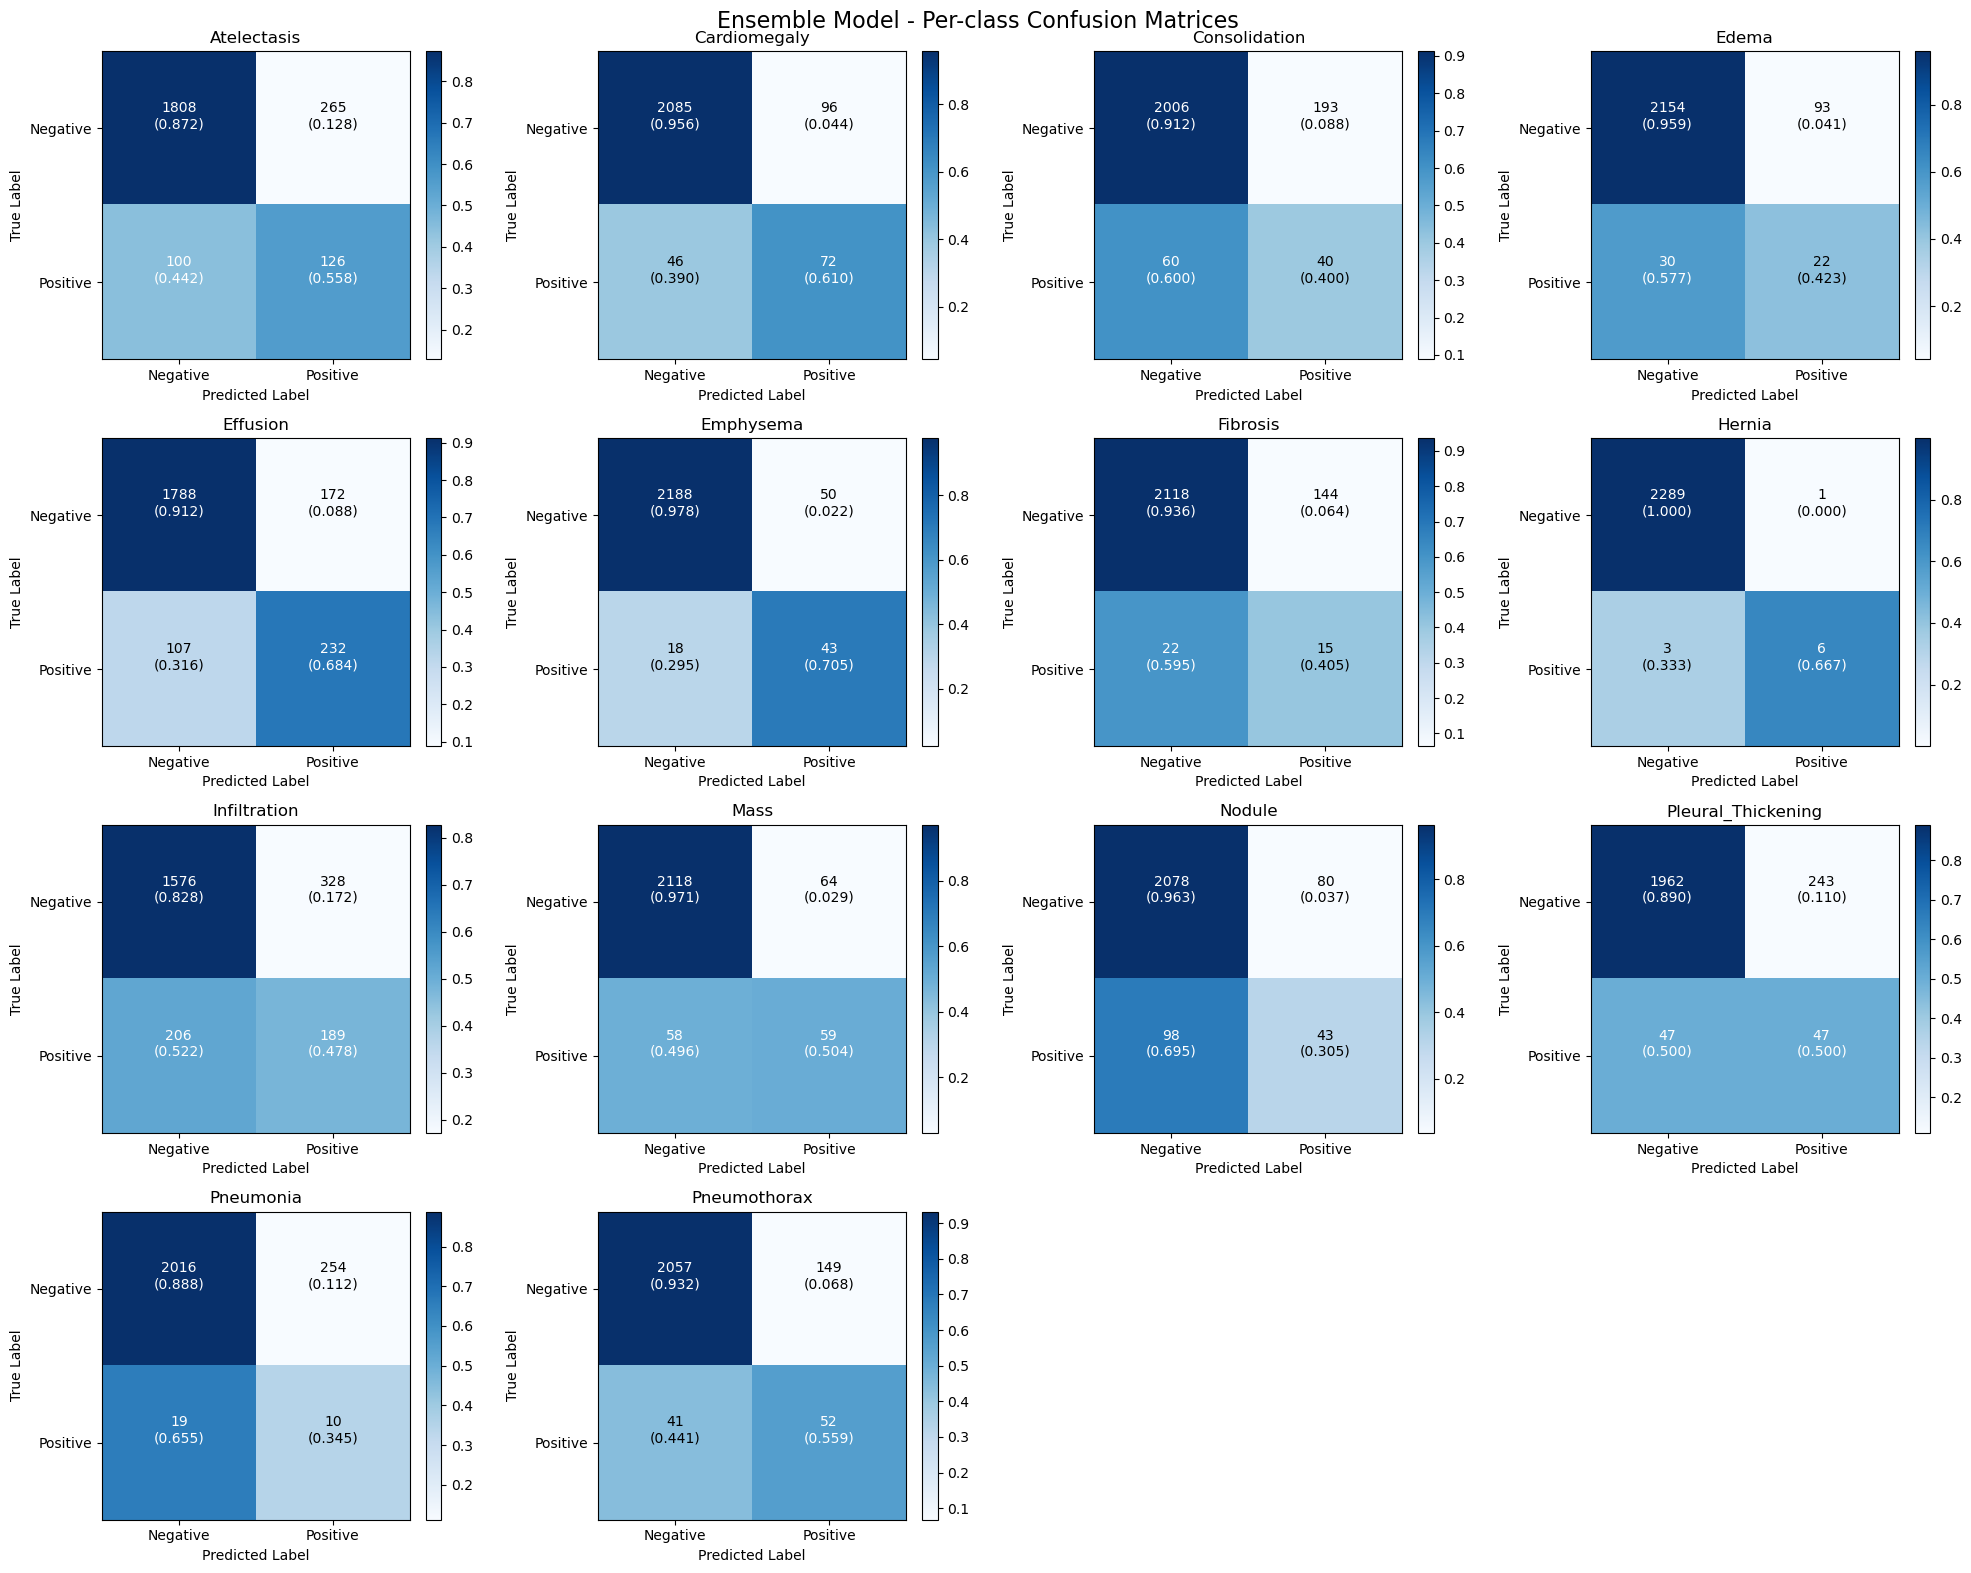

In [17]:
# Confusion Matrices for Each Disease Class
def plot_confusion_matrices(y_true, y_pred, disease_names, title="Per-class Confusion Matrices"):
    """Plot confusion matrices for each disease class"""
    # Convert predictions to binary using optimal thresholds
    y_pred_binary = np.zeros_like(y_pred)
    for i in range(y_pred.shape[1]):
        y_pred_binary[:, i] = (y_pred[:, i] > test_res['thresholds'][i]).astype(int)
    
    fig, axes = plt.subplots(4, 4, figsize=(20, 16))
    axes = axes.ravel()
    
    for i, disease in enumerate(disease_names):
        if i < len(axes):
            cm = confusion_matrix(y_true[:, i], y_pred_binary[:, i])
            
            # Normalize confusion matrix
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            
            im = axes[i].imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
            axes[i].set_title(f'{disease}')
            
            # Add colorbar
            plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
            
            # Add text annotations
            thresh = cm_normalized.max() / 2.
            for j in range(cm.shape[0]):
                for k in range(cm.shape[1]):
                    axes[i].text(k, j, f'{cm[j, k]}\n({cm_normalized[j, k]:.3f})',
                               horizontalalignment="center",
                               color="white" if cm_normalized[j, k] > thresh else "black",
                               fontsize=10)
            
            axes[i].set_ylabel('True Label')
            axes[i].set_xlabel('Predicted Label')
            axes[i].set_xticks([0, 1])
            axes[i].set_yticks([0, 1])
            axes[i].set_xticklabels(['Negative', 'Positive'])
            axes[i].set_yticklabels(['Negative', 'Positive'])
    
    # Hide empty subplots
    for i in range(len(disease_names), len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle(title, fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

# Plot confusion matrices
plot_confusion_matrices(test_labels_np, ensemble_test, disease_list, "Ensemble Model - Per-class Confusion Matrices")

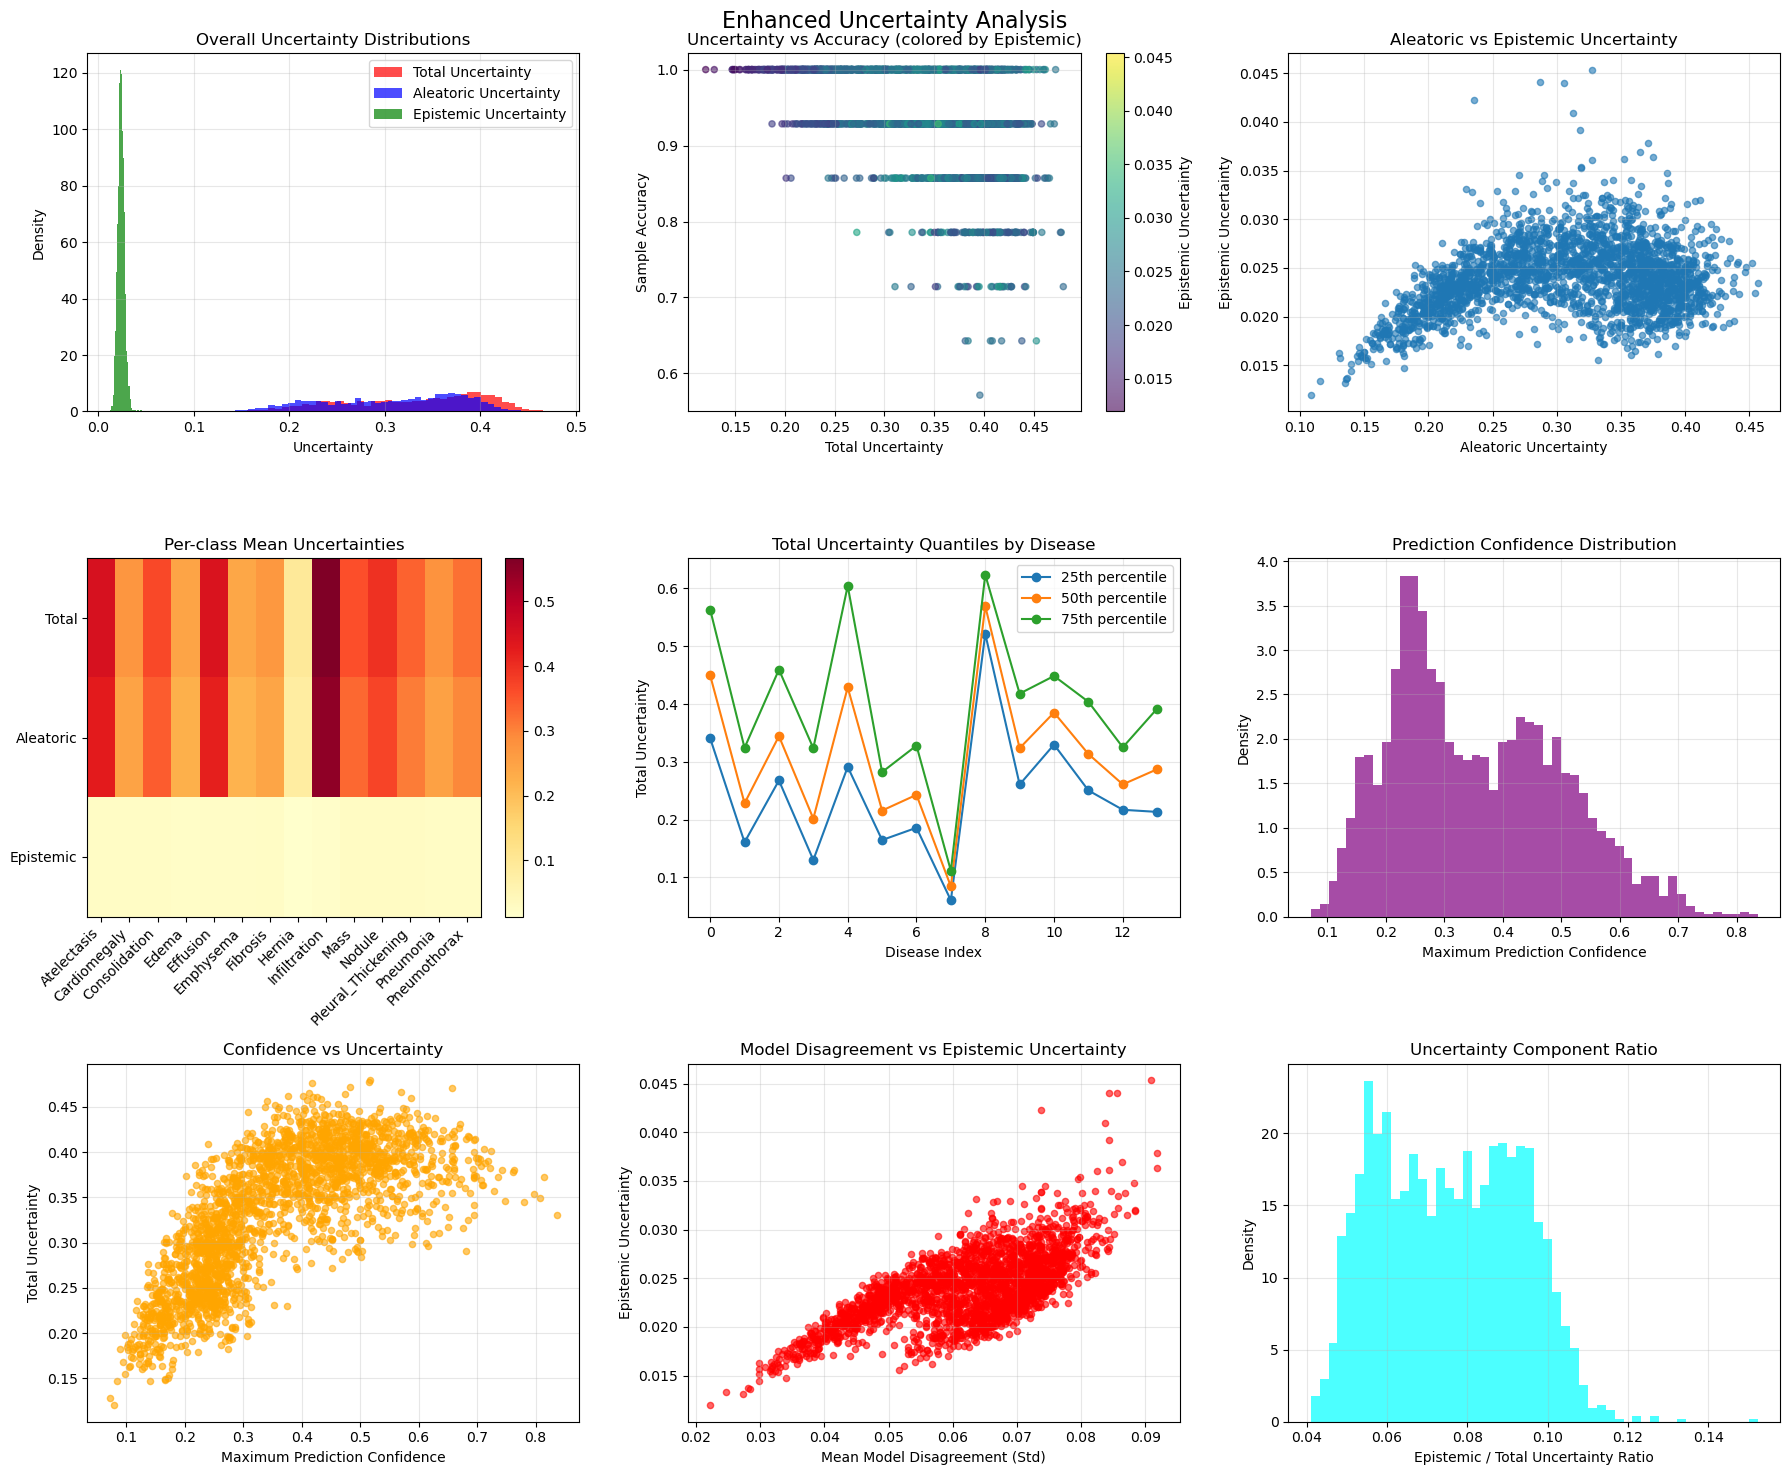

In [18]:
# Enhanced Uncertainty Distribution Analysis
def plot_uncertainty_distributions(uncertainty_results, disease_names, title="Uncertainty Distributions"):
    """Plot comprehensive uncertainty distribution analysis"""
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    
    # 1. Overall uncertainty distributions
    axes[0,0].hist(uncertainty_results['total_uncertainty'], bins=50, alpha=0.7, 
                   label='Total Uncertainty', density=True, color='red')
    axes[0,0].hist(uncertainty_results['aleatoric_uncertainty'], bins=50, alpha=0.7, 
                   label='Aleatoric Uncertainty', density=True, color='blue')
    axes[0,0].hist(uncertainty_results['epistemic_uncertainty'], bins=50, alpha=0.7, 
                   label='Epistemic Uncertainty', density=True, color='green')
    axes[0,0].set_xlabel('Uncertainty')
    axes[0,0].set_ylabel('Density')
    axes[0,0].set_title('Overall Uncertainty Distributions')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # 2. Uncertainty vs Sample accuracy
    ensemble_preds_binary = (ensemble_test > 0.5).astype(int)
    test_labels_np = test_labels.cpu().numpy() if hasattr(test_labels, 'cpu') else test_labels
    sample_accuracy = np.mean(ensemble_preds_binary == test_labels_np, axis=1)
    
    scatter = axes[0,1].scatter(uncertainty_results['total_uncertainty'], sample_accuracy, 
                               alpha=0.6, s=20, c=uncertainty_results['epistemic_uncertainty'], 
                               cmap='viridis')
    axes[0,1].set_xlabel('Total Uncertainty')
    axes[0,1].set_ylabel('Sample Accuracy')
    axes[0,1].set_title('Uncertainty vs Accuracy (colored by Epistemic)')
    plt.colorbar(scatter, ax=axes[0,1], label='Epistemic Uncertainty')
    axes[0,1].grid(True, alpha=0.3)

    # 3. Aleatoric vs Epistemic
    axes[0,2].scatter(uncertainty_results['aleatoric_uncertainty'], 
                     uncertainty_results['epistemic_uncertainty'], alpha=0.6, s=20)
    axes[0,2].set_xlabel('Aleatoric Uncertainty')
    axes[0,2].set_ylabel('Epistemic Uncertainty')
    axes[0,2].set_title('Aleatoric vs Epistemic Uncertainty')
    axes[0,2].grid(True, alpha=0.3)

    # 4. Per-class uncertainty heatmap
    uncertainty_matrix = np.array([
        [np.mean(uncertainty_results['per_class_tu'][:, i]) for i in range(len(disease_names))],
        [np.mean(uncertainty_results['per_class_au'][:, i]) for i in range(len(disease_names))],
        [np.mean(uncertainty_results['per_class_eu'][:, i]) for i in range(len(disease_names))]
    ])
    
    im = axes[1,0].imshow(uncertainty_matrix, cmap='YlOrRd', aspect='auto')
    axes[1,0].set_xticks(range(len(disease_names)))
    axes[1,0].set_xticklabels(disease_names, rotation=45, ha='right')
    axes[1,0].set_yticks([0, 1, 2])
    axes[1,0].set_yticklabels(['Total', 'Aleatoric', 'Epistemic'])
    axes[1,0].set_title('Per-class Mean Uncertainties')
    plt.colorbar(im, ax=axes[1,0])

    # 5. Uncertainty quantiles by disease
    quantiles = [0.25, 0.5, 0.75]
    disease_indices = range(len(disease_names))
    
    for q in quantiles:
        tu_quantiles = [np.quantile(uncertainty_results['per_class_tu'][:, i], q) for i in disease_indices]
        axes[1,1].plot(disease_indices, tu_quantiles, marker='o', label=f'{int(q*100)}th percentile')
    
    axes[1,1].set_xlabel('Disease Index')
    axes[1,1].set_ylabel('Total Uncertainty')
    axes[1,1].set_title('Total Uncertainty Quantiles by Disease')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

    # 6. Prediction confidence distribution
    prediction_confidence = np.max(ensemble_test, axis=1)
    axes[1,2].hist(prediction_confidence, bins=50, alpha=0.7, density=True, color='purple')
    axes[1,2].set_xlabel('Maximum Prediction Confidence')
    axes[1,2].set_ylabel('Density')
    axes[1,2].set_title('Prediction Confidence Distribution')
    axes[1,2].grid(True, alpha=0.3)

    # 7. Uncertainty vs prediction confidence
    axes[2,0].scatter(prediction_confidence, uncertainty_results['total_uncertainty'], 
                     alpha=0.6, s=20, color='orange')
    axes[2,0].set_xlabel('Maximum Prediction Confidence')
    axes[2,0].set_ylabel('Total Uncertainty')
    axes[2,0].set_title('Confidence vs Uncertainty')
    axes[2,0].grid(True, alpha=0.3)

    # 8. Model disagreement analysis
    model_std = np.std(test_probs, axis=0)  # Standard deviation across models
    mean_model_disagreement = np.mean(model_std, axis=1)
    
    axes[2,1].scatter(mean_model_disagreement, uncertainty_results['epistemic_uncertainty'], 
                     alpha=0.6, s=20, color='red')
    axes[2,1].set_xlabel('Mean Model Disagreement (Std)')
    axes[2,1].set_ylabel('Epistemic Uncertainty')
    axes[2,1].set_title('Model Disagreement vs Epistemic Uncertainty')
    axes[2,1].grid(True, alpha=0.3)

    # 9. Uncertainty components ratio
    uncertainty_ratio = uncertainty_results['epistemic_uncertainty'] / (
        uncertainty_results['total_uncertainty'] + 1e-8)
    
    axes[2,2].hist(uncertainty_ratio, bins=50, alpha=0.7, density=True, color='cyan')
    axes[2,2].set_xlabel('Epistemic / Total Uncertainty Ratio')
    axes[2,2].set_ylabel('Density')
    axes[2,2].set_title('Uncertainty Component Ratio')
    axes[2,2].grid(True, alpha=0.3)

    plt.suptitle(title, fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

# Plot enhanced uncertainty distributions
plot_uncertainty_distributions(uncertainty_results, disease_list, "Enhanced Uncertainty Analysis")

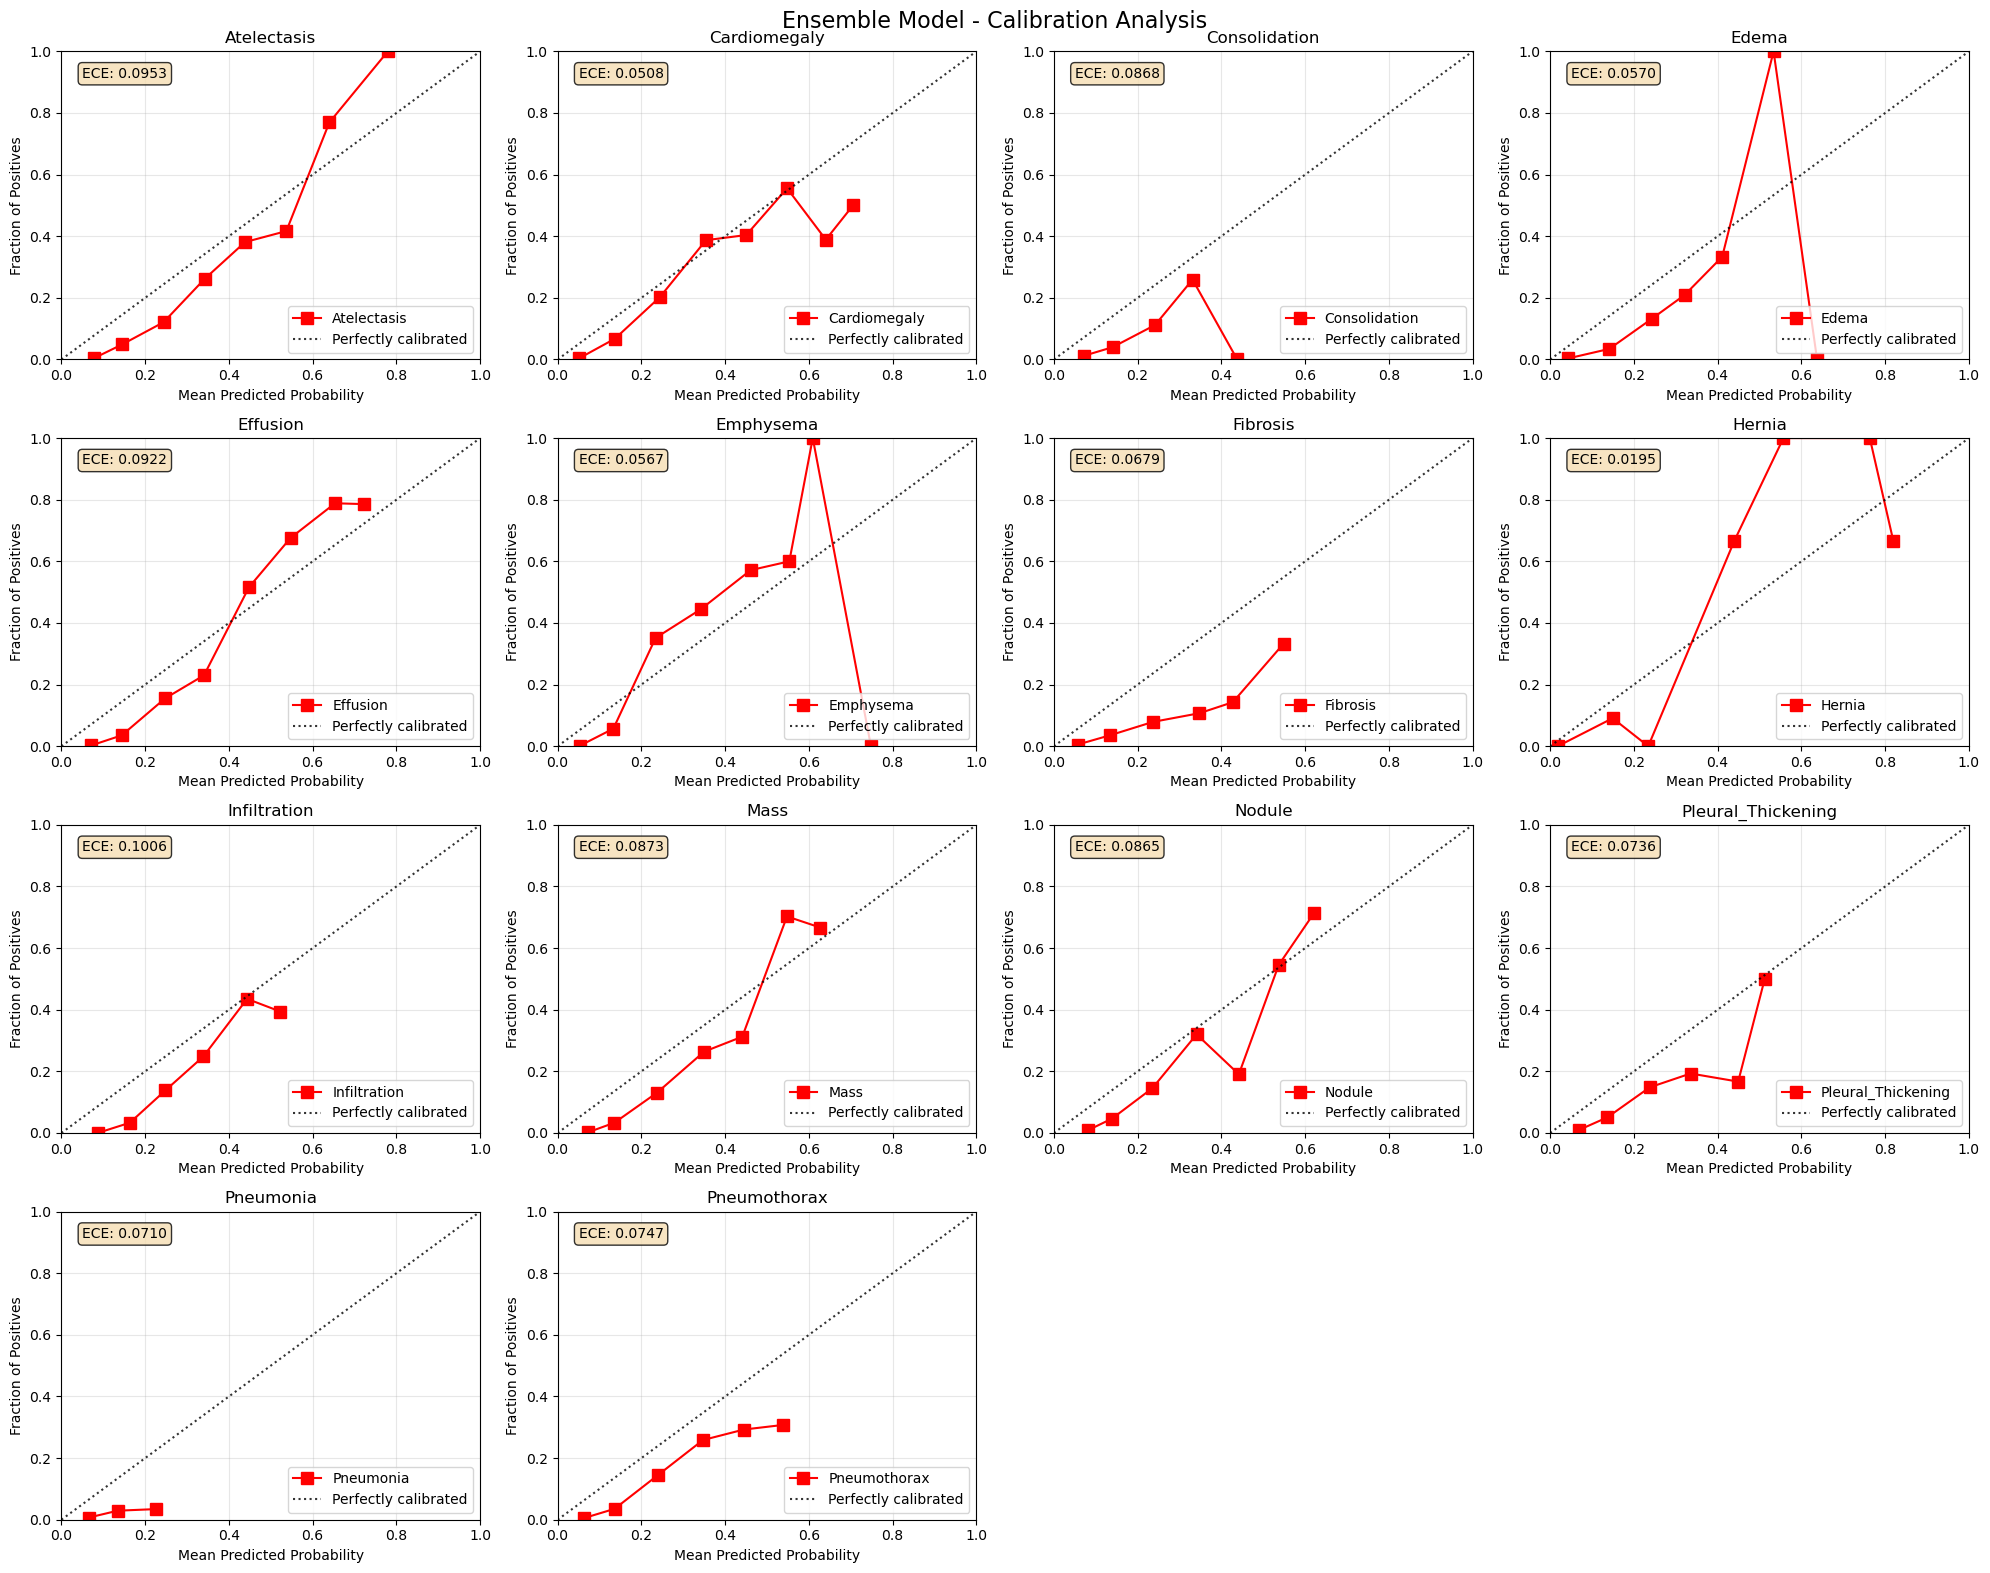

In [19]:
# Calibration Curves for Each Disease Class
def plot_calibration_curves(y_true, y_pred, disease_names, title="Per-class Calibration Curves"):
    """Plot calibration curves to assess model calibration"""
    fig, axes = plt.subplots(4, 4, figsize=(20, 16))
    axes = axes.ravel()
    
    for i, disease in enumerate(disease_names):
        if i < len(axes):
            # Calculate calibration curve
            fraction_of_positives, mean_predicted_value = calibration_curve(
                y_true[:, i], y_pred[:, i], n_bins=10)
            
            # Plot calibration curve
            axes[i].plot(mean_predicted_value, fraction_of_positives, "s-", 
                        label=f'{disease}', color='red', markersize=8)
            axes[i].plot([0, 1], [0, 1], "k:", label="Perfectly calibrated", alpha=0.8)
            
            # Calculate and display ECE for this class
            ece_score = additional_metrics['ece_scores'][i]
            axes[i].text(0.05, 0.95, f'ECE: {ece_score:.4f}', 
                        transform=axes[i].transAxes, fontsize=10,
                        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
            
            axes[i].set_xlabel('Mean Predicted Probability')
            axes[i].set_ylabel('Fraction of Positives')
            axes[i].set_title(f'{disease}')
            axes[i].legend(loc="lower right")
            axes[i].grid(True, alpha=0.3)
            axes[i].set_xlim([0, 1])
            axes[i].set_ylim([0, 1])
    
    # Hide empty subplots
    for i in range(len(disease_names), len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle(title, fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

# Plot calibration curves
plot_calibration_curves(test_labels_np, ensemble_test, disease_list, "Ensemble Model - Calibration Analysis")

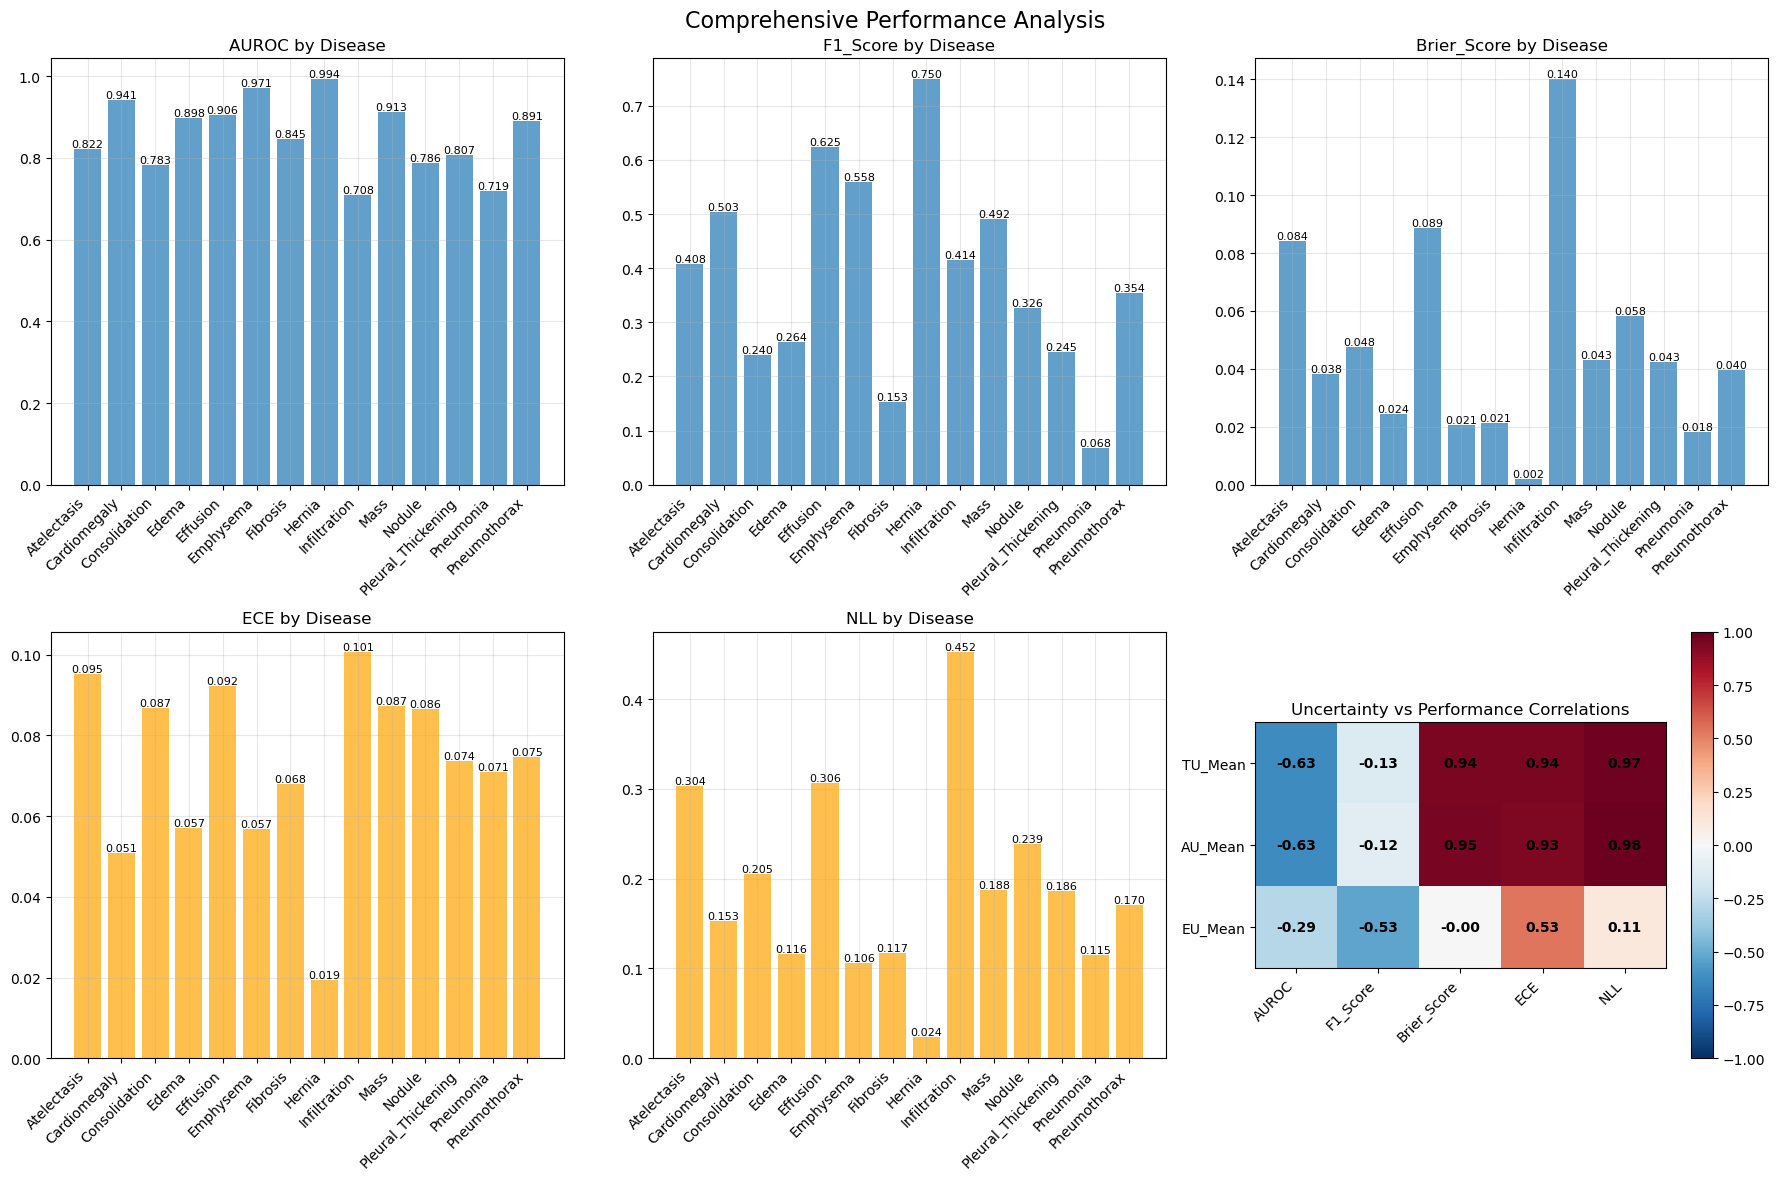

In [20]:
# Additional Comprehensive Visualization Plots
def plot_performance_summary(comprehensive_metrics_df, uncertainty_results, title="Model Performance Summary"):
    """Create a comprehensive performance summary visualization"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Performance metrics comparison
    metrics_to_plot = ['AUROC', 'F1_Score', 'Brier_Score', 'ECE', 'NLL']
    x_pos = np.arange(len(disease_list))
    
    for i, metric in enumerate(metrics_to_plot[:3]):
        if i < 3:
            row, col = 0, i
            bars = axes[row, col].bar(x_pos, comprehensive_metrics_df[metric], alpha=0.7)
            axes[row, col].set_title(f'{metric} by Disease')
            axes[row, col].set_xticks(x_pos)
            axes[row, col].set_xticklabels(disease_list, rotation=45, ha='right')
            axes[row, col].grid(True, alpha=0.3)
            
            # Add value labels on bars
            for bar, value in zip(bars, comprehensive_metrics_df[metric]):
                height = bar.get_height()
                axes[row, col].text(bar.get_x() + bar.get_width()/2., height,
                                   f'{value:.3f}', ha='center', va='bottom', fontsize=8)
    
    # 2. Calibration metrics
    metrics_to_plot_2 = ['ECE', 'NLL']
    for i, metric in enumerate(metrics_to_plot_2):
        row, col = 1, i
        bars = axes[row, col].bar(x_pos, comprehensive_metrics_df[metric], alpha=0.7, color='orange')
        axes[row, col].set_title(f'{metric} by Disease')
        axes[row, col].set_xticks(x_pos)
        axes[row, col].set_xticklabels(disease_list, rotation=45, ha='right')
        axes[row, col].grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, value in zip(bars, comprehensive_metrics_df[metric]):
            height = bar.get_height()
            axes[row, col].text(bar.get_x() + bar.get_width()/2., height,
                               f'{value:.3f}', ha='center', va='bottom', fontsize=8)
    
    # 3. Uncertainty vs Performance correlation heatmap
    uncertainty_metrics = ['TU_Mean', 'AU_Mean', 'EU_Mean']
    performance_metrics = ['AUROC', 'F1_Score', 'Brier_Score', 'ECE', 'NLL']
    
    correlations = np.zeros((len(uncertainty_metrics), len(performance_metrics)))
    for i, u_metric in enumerate(uncertainty_metrics):
        for j, p_metric in enumerate(performance_metrics):
            correlations[i, j] = np.corrcoef(comprehensive_metrics_df[u_metric], 
                                           comprehensive_metrics_df[p_metric])[0, 1]
    
    im = axes[1, 2].imshow(correlations, cmap='RdBu_r', vmin=-1, vmax=1)
    axes[1, 2].set_xticks(range(len(performance_metrics)))
    axes[1, 2].set_yticks(range(len(uncertainty_metrics)))
    axes[1, 2].set_xticklabels(performance_metrics, rotation=45, ha='right')
    axes[1, 2].set_yticklabels(uncertainty_metrics)
    axes[1, 2].set_title('Uncertainty vs Performance Correlations')
    
    # Add correlation values
    for i in range(len(uncertainty_metrics)):
        for j in range(len(performance_metrics)):
            text = axes[1, 2].text(j, i, f'{correlations[i, j]:.2f}',
                                  ha="center", va="center", color="black", fontweight='bold')
    
    plt.colorbar(im, ax=axes[1, 2])
    
    plt.suptitle(title, fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

# Plot performance summary
plot_performance_summary(comprehensive_metrics_df, uncertainty_results, "Comprehensive Performance Analysis")

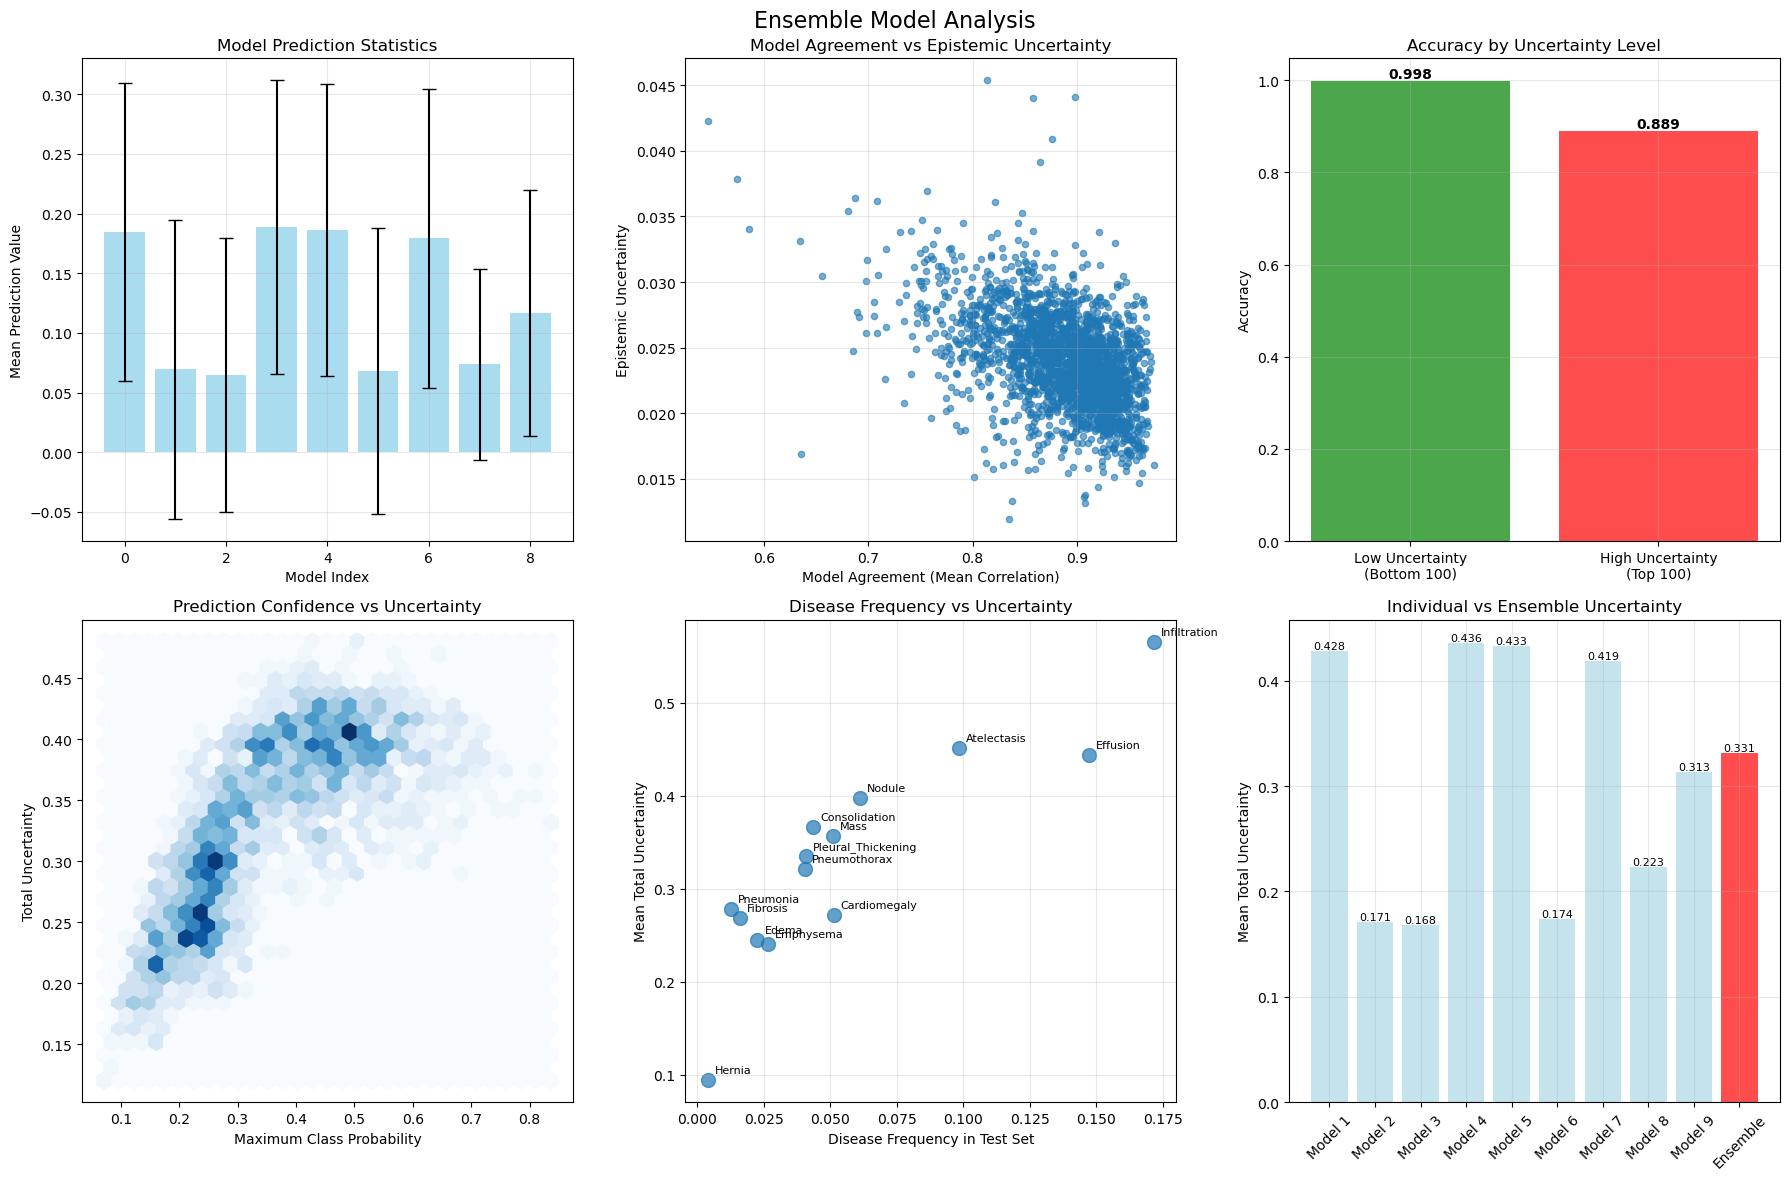

In [21]:
# Model Ensemble Analysis and Uncertainty-based Sample Analysis
def plot_ensemble_analysis(test_probs, uncertainty_results, test_labels, ensemble_test):
    """Analyze ensemble behavior and high-uncertainty samples"""
    # Ensure test_labels is numpy array
    test_labels_np = test_labels.cpu().numpy() if hasattr(test_labels, 'cpu') else test_labels
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Individual model prediction distribution
    model_means = np.mean(test_probs, axis=(1, 2))  # Mean prediction per model
    model_stds = np.std(test_probs, axis=(1, 2))    # Std prediction per model
    
    axes[0, 0].bar(range(len(model_means)), model_means, alpha=0.7, 
                   yerr=model_stds, capsize=5, color='skyblue')
    axes[0, 0].set_title('Model Prediction Statistics')
    axes[0, 0].set_xlabel('Model Index')
    axes[0, 0].set_ylabel('Mean Prediction Value')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Model agreement analysis
    model_agreement = np.zeros(test_probs.shape[1])  # Agreement per sample
    for i in range(test_probs.shape[1]):
        sample_preds = test_probs[:, i, :]  # All model predictions for sample i
        # Calculate pairwise correlation between models for this sample
        if len(sample_preds) > 1:
            correlations = []
            for j in range(len(sample_preds)):
                for k in range(j+1, len(sample_preds)):
                    corr = np.corrcoef(sample_preds[j], sample_preds[k])[0, 1]
                    if not np.isnan(corr):
                        correlations.append(corr)
            model_agreement[i] = np.mean(correlations) if correlations else 0
    
    axes[0, 1].scatter(model_agreement, uncertainty_results['epistemic_uncertainty'], 
                      alpha=0.6, s=20)
    axes[0, 1].set_xlabel('Model Agreement (Mean Correlation)')
    axes[0, 1].set_ylabel('Epistemic Uncertainty')
    axes[0, 1].set_title('Model Agreement vs Epistemic Uncertainty')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. High uncertainty sample analysis
    high_uncertainty_idx = np.argsort(uncertainty_results['total_uncertainty'])[-100:]
    low_uncertainty_idx = np.argsort(uncertainty_results['total_uncertainty'])[:100]
    
    high_uncertainty_acc = np.mean((ensemble_test[high_uncertainty_idx] > 0.5) == 
                                  test_labels_np[high_uncertainty_idx])
    low_uncertainty_acc = np.mean((ensemble_test[low_uncertainty_idx] > 0.5) == 
                                 test_labels_np[low_uncertainty_idx])
    
    uncertainty_groups = ['Low Uncertainty\n(Bottom 100)', 'High Uncertainty\n(Top 100)']
    accuracies = [low_uncertainty_acc, high_uncertainty_acc]
    
    bars = axes[0, 2].bar(uncertainty_groups, accuracies, alpha=0.7, 
                         color=['green', 'red'])
    axes[0, 2].set_title('Accuracy by Uncertainty Level')
    axes[0, 2].set_ylabel('Accuracy')
    axes[0, 2].grid(True, alpha=0.3)
    
    # Add accuracy values on bars
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        axes[0, 2].text(bar.get_x() + bar.get_width()/2., height,
                       f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 4. Prediction confidence vs uncertainty
    max_probs = np.max(ensemble_test, axis=1)
    axes[1, 0].hexbin(max_probs, uncertainty_results['total_uncertainty'], 
                     gridsize=30, cmap='Blues')
    axes[1, 0].set_xlabel('Maximum Class Probability')
    axes[1, 0].set_ylabel('Total Uncertainty')
    axes[1, 0].set_title('Prediction Confidence vs Uncertainty')
    
    # 5. Disease frequency vs uncertainty
    disease_frequencies = np.mean(test_labels_np, axis=0)
    disease_uncertainties = [np.mean(uncertainty_results['per_class_tu'][:, i]) 
                           for i in range(len(disease_list))]
    
    axes[1, 1].scatter(disease_frequencies, disease_uncertainties, s=100, alpha=0.7)
    for i, disease in enumerate(disease_list):
        axes[1, 1].annotate(disease, (disease_frequencies[i], disease_uncertainties[i]),
                           xytext=(5, 5), textcoords='offset points', fontsize=8)
    axes[1, 1].set_xlabel('Disease Frequency in Test Set')
    axes[1, 1].set_ylabel('Mean Total Uncertainty')
    axes[1, 1].set_title('Disease Frequency vs Uncertainty')
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Ensemble vs Individual model uncertainty
    individual_uncertainties = []
    for i in range(test_probs.shape[0]):  # For each model
        individual_pred = test_probs[i]
        individual_unc = np.mean(binary_entropy(individual_pred), axis=1)
        individual_uncertainties.append(np.mean(individual_unc))
    
    ensemble_mean_uncertainty = np.mean(uncertainty_results['total_uncertainty'])
    
    x_labels = [f'Model {i+1}' for i in range(len(individual_uncertainties))] + ['Ensemble']
    y_values = individual_uncertainties + [ensemble_mean_uncertainty]
    colors = ['lightblue'] * len(individual_uncertainties) + ['red']
    
    bars = axes[1, 2].bar(x_labels, y_values, alpha=0.7, color=colors)
    axes[1, 2].set_title('Individual vs Ensemble Uncertainty')
    axes[1, 2].set_ylabel('Mean Total Uncertainty')
    axes[1, 2].tick_params(axis='x', rotation=45)
    axes[1, 2].grid(True, alpha=0.3)
    
    # Add values on bars
    for bar, value in zip(bars, y_values):
        height = bar.get_height()
        axes[1, 2].text(bar.get_x() + bar.get_width()/2., height,
                       f'{value:.3f}', ha='center', va='bottom', fontsize=8)
    
    plt.suptitle('Ensemble Model Analysis', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

# Plot ensemble analysis
plot_ensemble_analysis(test_probs, uncertainty_results, test_labels, ensemble_test)

In [22]:
# Fix binary_entropy function to ensure NumPy compatibility
def binary_entropy(probs, epsilon=1e-10):
    """Calculate binary entropy for sigmoid probabilities using NumPy"""
    probs = np.clip(probs, epsilon, 1 - epsilon)
    return -probs * np.log(probs) - (1 - probs) * np.log(1 - probs)

In [23]:
# Summary and Key Insights
print("="*80)
print("COMPREHENSIVE ENSEMBLE UNCERTAINTY QUANTIFICATION SUMMARY")
print("="*80)

print(f"\n PERFORMANCE METRICS:")
print(f"   • Average AUROC: {test_res['avg_auc']:.4f}")
print(f"   • Average F1 Score: {test_res['avg_f1']:.4f}")
print(f"   • Mean Brier Score: {additional_metrics['mean_brier']:.4f}")
print(f"   • Mean ECE: {additional_metrics['mean_ece']:.4f}")
print(f"   • Mean NLL: {additional_metrics['mean_nll']:.4f}")

print(f"\n UNCERTAINTY ANALYSIS:")
print(f"   • Total Uncertainty: {np.mean(uncertainty_results['total_uncertainty']):.4f} ± {np.std(uncertainty_results['total_uncertainty']):.4f}")
print(f"   • Aleatoric Uncertainty: {np.mean(uncertainty_results['aleatoric_uncertainty']):.4f} ± {np.std(uncertainty_results['aleatoric_uncertainty']):.4f}")
print(f"   • Epistemic Uncertainty: {np.mean(uncertainty_results['epistemic_uncertainty']):.4f} ± {np.std(uncertainty_results['epistemic_uncertainty']):.4f}")

epistemic_ratio = np.mean(uncertainty_results['epistemic_uncertainty']) / np.mean(uncertainty_results['total_uncertainty'])
print(f"   • Epistemic/Total Ratio: {epistemic_ratio:.3f} ({epistemic_ratio*100:.1f}%)")

print(f"\n BEST PERFORMING DISEASES (by AUROC):")
best_diseases = comprehensive_metrics_df.nlargest(3, 'AUROC')[['Disease', 'AUROC', 'F1_Score']]
for _, row in best_diseases.iterrows():
    print(f"   • {row['Disease']}: AUROC={row['AUROC']:.4f}, F1={row['F1_Score']:.4f}")

print(f"\n MOST UNCERTAIN DISEASES:")
most_uncertain = comprehensive_metrics_df.nlargest(3, 'TU_Mean')[['Disease', 'TU_Mean', 'EU_Mean']]
for _, row in most_uncertain.iterrows():
    print(f"   • {row['Disease']}: TU={row['TU_Mean']:.4f}, EU={row['EU_Mean']:.4f}")

print(f"\n CALIBRATION QUALITY:")
best_calibrated = comprehensive_metrics_df.nsmallest(3, 'ECE')[['Disease', 'ECE', 'Brier_Score']]
print("   Best Calibrated:")
for _, row in best_calibrated.iterrows():
    print(f"   • {row['Disease']}: ECE={row['ECE']:.4f}, Brier={row['Brier_Score']:.4f}")

print(f"\n MODEL ENSEMBLE INSIGHTS:")
print(f"   • Number of models in ensemble: {len(models)}")
print(f"   • Individual model performance range: {min(individual_test_aurocs):.4f} - {max(individual_test_aurocs):.4f}")
print(f"   • Ensemble improvement over best individual: +{test_res['avg_auc'] - max(individual_test_aurocs):.4f}")

# Uncertainty utilization
max_possible_uncertainty = np.log(2)  # Maximum binary entropy
utilization = np.mean(uncertainty_results['total_uncertainty']) / max_possible_uncertainty * 100
print(f"   • Uncertainty space utilization: {utilization:.1f}%")

print("="*80)

COMPREHENSIVE ENSEMBLE UNCERTAINTY QUANTIFICATION SUMMARY

 PERFORMANCE METRICS:
   • Average AUROC: 0.8559
   • Average F1 Score: 0.3857
   • Mean Brier Score: 0.0478
   • Mean ECE: 0.0728
   • Mean NLL: 0.1916

 UNCERTAINTY ANALYSIS:
   • Total Uncertainty: 0.3312 ± 0.0730
   • Aleatoric Uncertainty: 0.3073 ± 0.0720
   • Epistemic Uncertainty: 0.0240 ± 0.0036
   • Epistemic/Total Ratio: 0.072 (7.2%)

 BEST PERFORMING DISEASES (by AUROC):
   • Hernia: AUROC=0.9937, F1=0.7500
   • Emphysema: AUROC=0.9705, F1=0.5584
   • Cardiomegaly: AUROC=0.9405, F1=0.5035

 MOST UNCERTAIN DISEASES:
   • Infiltration: TU=0.5660, EU=0.0193
   • Atelectasis: TU=0.4512, EU=0.0245
   • Effusion: TU=0.4444, EU=0.0235

 CALIBRATION QUALITY:
   Best Calibrated:
   • Hernia: ECE=0.0195, Brier=0.0021
   • Cardiomegaly: ECE=0.0508, Brier=0.0383
   • Emphysema: ECE=0.0567, Brier=0.0208

 MODEL ENSEMBLE INSIGHTS:
   • Number of models in ensemble: 9
   • Individual model performance range: 0.8117 - 0.8514
   • En